Progetto per **Streaming Data Management and Time Series Analysis**

---

Matricola: **847548**

Studente: **Massimiliano Perletti**

# Librerie

---



Vengono importati i pacchetti necessari per il progetto, e preparato l'env colab per lavorare sulla piattaforma Google

In [0]:
# base
import pandas as pd
import numpy as np
import time
import datetime
from tqdm import tqdm_notebook
import holidays
import warnings
warnings.filterwarnings("ignore")

# time series analysis
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima_model import ARIMA

# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# keras models
from keras.layers import LSTM, Dense, GRU, CuDNNGRU, CuDNNLSTM, Activation, BatchNormalization, Dropout, LeakyReLU
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l1
from keras import backend as K
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint

# visualizzazione
import seaborn as sns
sns.set_style('darkgrid', {"axes.facecolor": "0.94"})
sns.set_color_codes(palette='pastel')
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# class for pretty print
class text:
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# env colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Caricamento dati

---



Carichiamo i dati resi a disposizione per il task

In [50]:
path = '/content/gdrive/My Drive/Colab Notebooks/SDMTSA/time_series_dataset.csv'
data_load = pd.read_csv(path, sep = ';')
data_load['date'] = pd.to_datetime(data_load['Data'])
df = data_load.loc[:, ['value']]
df = df.set_index(data_load.date)
df.head()

,value
date,
2010-01-01,41.651044
2010-01-02,131.286604
2010-01-03,117.388117
2010-01-04,116.461280
2010-01-05,123.823765


Andiamo a visualizzare graficamente come si presenta la nostra time series

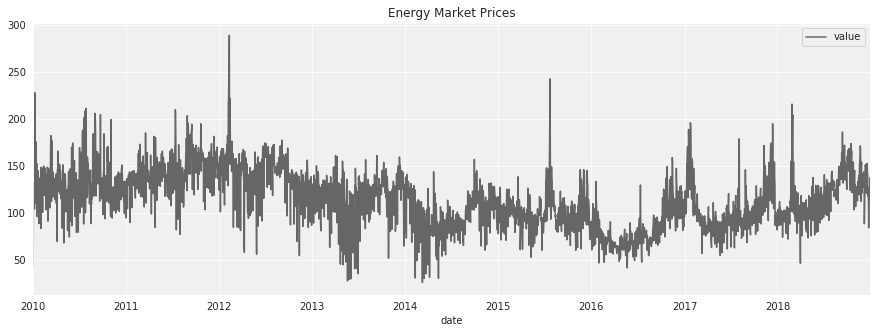

In [0]:
df.plot(figsize=(15,5), color = '#666666')
plt.title('Energy Market Prices')
plt.show()

Andiamo poi ad effettuare il test **Dickey-Fuller** per la stazionarietà della serie

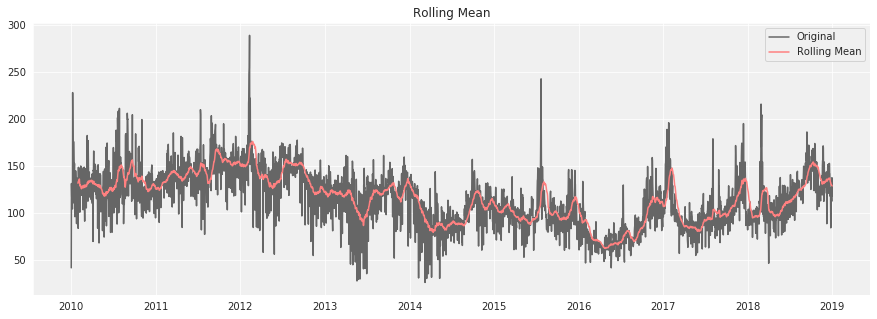


Dickey-Fuller Test

Test Statistic                   -3.456585
p-value                           0.009175
#Lags Used                       28.000000
Number of Observations Used    3258.000000
Critical Value (1%)              -3.432359
Critical Value (5%)              -2.862428
Critical Value (10%)             -2.567242
dtype: float64


In [0]:
plt.figure(figsize=(15,5))
rolmean = df.value.rolling(window=30).mean()
plt.plot(df.value, color = '#666666', label = 'Original')
plt.plot(rolmean, color='#ff8080', label = 'Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show()

# Augmented Dickey-Fuller unit root test
print ('\n'+text.BOLD+text.UNDERLINE+'Dickey-Fuller Test\n'+text.END)
adftest = adfuller(df.value, autolag='AIC')
res = pd.Series(adftest[0:4],
                      index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for k,kvalue in adftest[4].items():
    res['Critical Value ({})'.format(str(k))] = kvalue
print(res)

è possibile vedere come il p-value risulti piccolo (significativà 1%), rifiutando quindi l'ipotesi nulla (ossia che almeno una radice carattersitica è uguale ad 1). Non sembra esserci il bisogno quindi di trasformare i nostri dati, che verrano usati nella loro forma originale

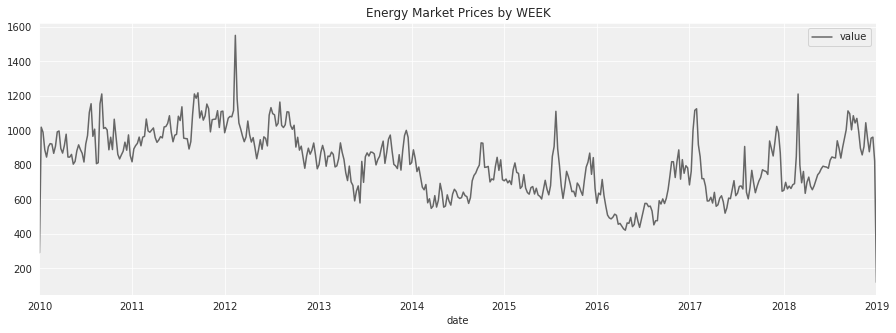

In [0]:
weekly = df.resample('W').sum()
weekly.plot(style = ['-'], figsize = (15,5), color = '#666666')
plt.title('Energy Market Prices by WEEK')
plt.show()

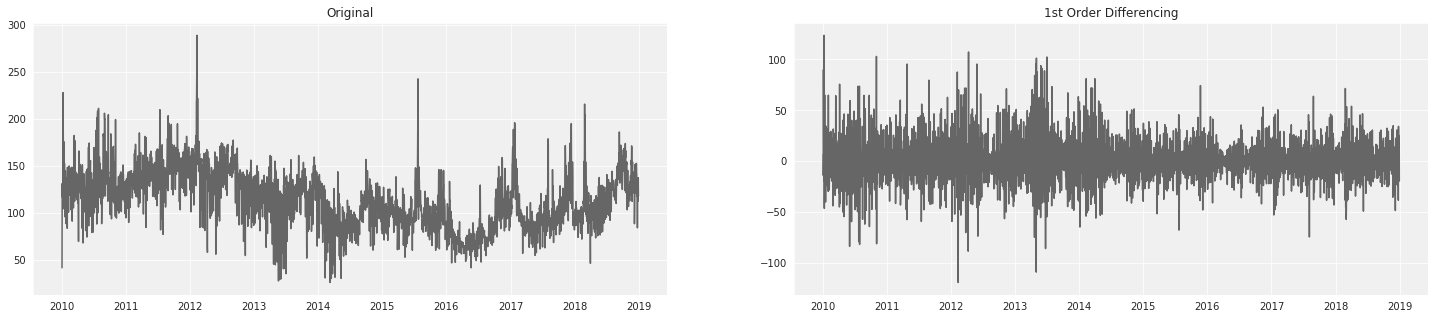

In [0]:
plt.rcParams.update({'figure.figsize':(25,5)})
fig0, axes0 = plt.subplots(1, 2, sharex=True)

axes0[0].plot(df.value, color = '#666666')
axes0[0].set_title('Original')

axes0[1].plot(df.diff(1).dropna(), color = '#666666');
axes0[1].set_title('1st Order Differencing')
plt.show()

è visibile come ci sia una sorta di differenzazione della serie da integrare 

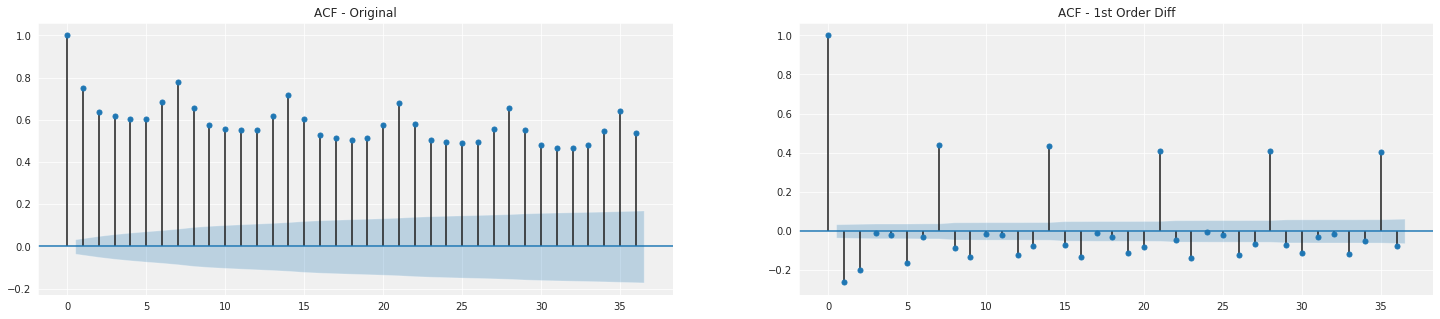

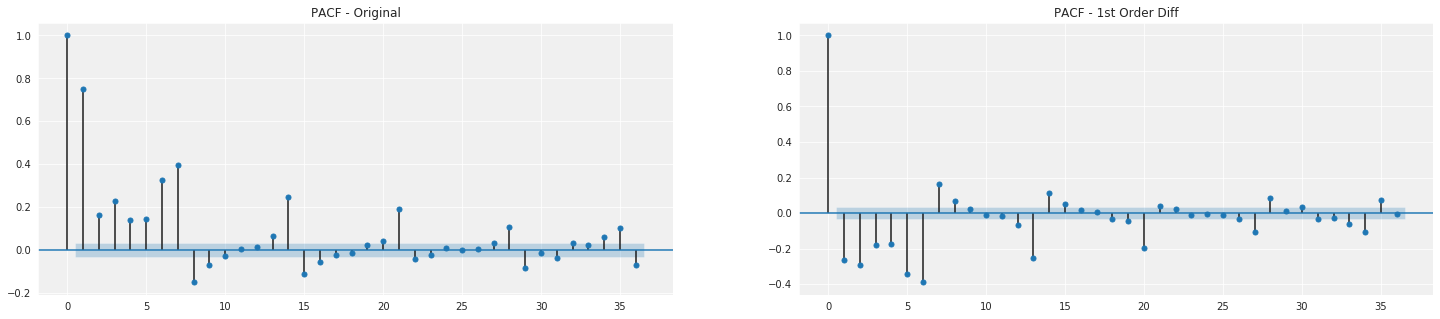

In [0]:
plt.rcParams.update({'figure.figsize':(25,5)})
fig1, axes1 = plt.subplots(1, 2, sharex=True)
plot_acf(df, ax=axes1[0])
axes1[0].set_title('ACF - Original')
plot_acf(df.diff(1).dropna(), ax=axes1[1]); axes1[1].set_title('ACF - 1st Order Diff')
plt.show()

fig2, axes2 = plt.subplots(1, 2, sharex=True)
plot_pacf(df, ax=axes2[0])
axes2[0].set_title('PACF - Original')
plot_pacf(df.diff(1).dropna(), ax=axes2[1])
axes2[1].set_title('PACF - 1st Order Diff')
plt.show()

Si procede dunque dividendo training e validation set (8 anni - 1 anno)

In [0]:
train = df[df.index <= ('2017-12-31')]
val = df[df.index > ('2017-12-31')]

In [0]:
print(text.BOLD+'Observations Train:'+text.END+' {} --- {}%'.format(len(train), (round(len(train)/len(df), 4))*100))
print(text.BOLD+'Observations Validation:'+text.END+' {} --- {}%'.format(len(val), (round(len(val)/len(df), 4))*100))

Observations Train: 2922 --- 88.9%
Observations Validation: 365 --- 11.1%


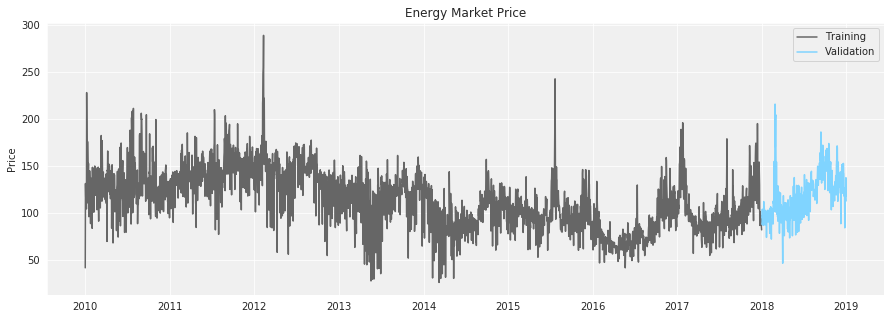

In [0]:
fig = plt.figure(figsize=(15,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Energy Market Price')
ax.plot(train, color='#666666', label='Training')
ax.plot(val, color='#80d4ff', label='Validation')
plt.ylabel('Price')
plt.legend()
plt.show()

# Funzioni

---



Vengono ora definite alcune funzioni utili per lo sviluppo e la valutazione dei successivi modelli da applicare (Arima, Ucm, Rnn)

In [0]:
# function model ARIMA
def SARIMAX(data, exog, p, d, q, P = 0, D = 0, Q = 0, s = 0, reg = 'no'):
  if reg == 'no':
    model = sm.tsa.statespace.SARIMAX(data,
                    order=(p,d,q),
                    seasonal_order=(P, D, Q, s),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model = model.fit(disp=0)
  else:
    model = sm.tsa.statespace.SARIMAX(data,
                    order=(p,d,q),
                    seasonal_order=(P, D, Q, s),
                    exog = exog,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model = model.fit(disp=0)
  
  return model

In [0]:
# function for autocorrelogram (and partial)
def plot_ACF_PACF(model):
    plt.rcParams.update({'figure.figsize':(25,5)})
    residuals = pd.DataFrame(model.resid)
    fig1, axes1 = plt.subplots(1, 2, sharex=True)
    plot_acf(residuals, lags=49, ax=axes1[0])
    axes1[0].set_title('ACF')
    plot_pacf(residuals, lags=49, ax=axes1[1])
    axes1[1].set_title('PACF')
    plt.show()

In [0]:
# function for prediction (with Viz)
def prediction_SARIMAX_UCM(model, train, val, exog_train, exog_val, exog = 0):
    
    if exog == 0:
    # predict for evaluate on TRAIN
      predicted_train = model.get_prediction(start=train.index[0], end=train.index[-1])
      predicted_train_mean = predicted_train.predicted_mean
      # predict for evaluate on VAL
      predicted_val = model.get_prediction(start=val.index[0], end=val.index[-1])
      predicted_val_mean = predicted_val.predicted_mean

    else:
      # predict for evaluate on TRAIN
      predicted_train = model.get_prediction(start=train.index[0], end=train.index[-1], exog = exog_train)
      predicted_train_mean = predicted_train.predicted_mean
      # predict for evaluate on VAL
      predicted_val = model.get_prediction(start=val.index[0], end=val.index[-1], exog = exog_val)
      predicted_val_mean = predicted_val.predicted_mean
      
    return predicted_train_mean, predicted_val_mean

# function for plot prediction on TRAIN, VAl
def plot_PREDICTION(train, val, pred_train, pred_val):
  # figure on train
  fig = plt.figure(figsize=(15,15))
  fig.show()
  ax = fig.add_subplot(311)
  plt.title('Prediction on TRAIN')
  ax.plot(train, color='#666666', label='Real')
  ax.plot(pred_train, color='#ff8080', label='Predect')
  plt.ylabel('Price')
  plt.legend()
  plt.show()
  # figure on val
  fig = plt.figure(figsize=(15,15))
  fig.show()
  ax = fig.add_subplot(312)
  plt.title('Prediction on VAL')
  ax.plot(train, color='#666666', label='Train')
  ax.plot(val, color='#80d4ff', label='Real')
  ax.plot(pred_val, color='#ff8080', label='Predect')
  plt.ylabel('Price')
  plt.legend()
  plt.show()
  # figure only val
  fig = plt.figure(figsize=(15,15))
  fig.show()
  ax = fig.add_subplot(313)
  plt.title('Focus on VAL')
  ax.plot(val, color='#80d4ff', label='Real')
  ax.plot(pred_val, color='#ff8080', label='Predect')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

In [0]:
# function for create timeSeries
def create_timeSeries(data, window):
  x = []
  y = []
  for i in range(len(data) - window):
    ts0 = data[i:i+window]
    ts1 = data[i+window:i+window+1]
    x.append(ts0)
    y.append(ts1)
  return np.array(x), np.array(y)

In [0]:
# function for prediction RNN
def prediction_RNN(model, data, look_back, window_pred , index, val_data=1):
    
    if val_data==0: 
        prediction = []
        
        for i in range(window_pred):
            input_data = data[i:look_back+i].tolist()
            seq = np.array(input_data)
            pred = model.predict(seq.reshape(1,1,-1))
            prediction.append(pred)
           
        pred_final = scaler.inverse_transform(np.array(prediction).reshape(-1,1))
        pred_final = pd.DataFrame(pred_final, index=index, columns=['value'])
        
    else:
        input_data=data[-look_back:].tolist()
        
        for i in range(window_pred):
            seq = np.array(input_data[-look_back:])
            prediction=model.predict(seq.reshape(1,1,-1))
            input_data.append(prediction)
    
        pred_final = input_data[-window_pred:]
        pred_final = scaler.inverse_transform(np.array(pred_final).reshape(-1,1))
        pred_final = pd.DataFrame(pred_final, index=index, columns=['value'])
        
    return pred_final

In [0]:
# function for plot history (model ML)
def model_plot(history, flag_NOvalidation = 0):
  
  if flag_NOvalidation == 0:
    fig, axes = plt.subplots(1, 2, figsize = (20, 5))
    colors = ['lightsalmon', 'lightblue']

    axes[0].set_title('Model Loss')
    axes[0].plot(history['loss'], color = colors[0])
    axes[0].plot(history['val_loss'], color = colors[1])
    
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['train', 'val'], loc='upper right')

    axes[1].set_title('Model MAPE')
    axes[1].plot(history['mean_absolute_percentage_error'], color = colors[0])
    axes[1].plot(history['val_mean_absolute_percentage_error'], color = colors[1])
    
    axes[1].set_ylabel('MAPE')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['train', 'val'], loc='upper right')

  if flag_NOvalidation == 1:
    fig, axes = plt.subplots(1, 2, figsize = (20, 5))
    colors = ['lightsalmon', 'lightblue']

    axes[0].set_title('Model Loss')
    axes[0].plot(history['loss'], color = colors[0])
    
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['train'], loc='upper right')

    axes[1].set_title('Model MAPE')
    axes[1].plot(history['mean_absolute_percentage_error'], color = colors[0])
    
    axes[1].set_ylabel('MAPE')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['train'], loc='upper right')

Come funzione/metrica di valutazione viene usato il MAPE, sotto definito

In [0]:
# function for evaluation
def error_eval(function, pred_train, pred_val, base = None, window = None, verbose = 0):
    if base == None:
      MAPE_train = function(train[1:].value, pred_train[1:])
      MAPE_val = function(val.value, pred_val)
      if verbose == 1:
        print(text.BOLD+'MAPE Train:'+text.END+' {}'.format(MAPE_train))
        print(text.BOLD+'MAPE Validation:'+text.END+' {}'.format(MAPE_val))

    if base == 'ML':
      MAPE_train = function(train[window:].value, pred_train.value)
      MAPE_val = function(val.value, pred_val.value)
      if verbose == 1:
        print(text.BOLD+'MAPE Train:'+text.END+' {}'.format(MAPE_train))
        print(text.BOLD+'MAPE Validation:'+text.END+' {}'.format(MAPE_val))

    return MAPE_train, MAPE_val

def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Regressori esterni

---



Vengono ora creati alcune matrici di regressori esterni, sotto forma di dummy, da usare successivamente come integrazione per i modelli



```
Lista degli array con regressori esterni

REG_FESTE_train
REG_FESTE_val

REG_FREQ_train
REG_FREQ_val

REG_FESTE_FREQ_train
REG_FESTE_FREQ_val

REG_FESTE (senza divisione train/val)
```



## **Regressori feste**

In [0]:
# exog train con regressori feste 
ind = []
cat = []
for ptr in holidays.Italy(years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]).items(): 
    ind.append(ptr[0])
    cat.append(ptr[1])
hol = pd.DataFrame(data=cat, index=ind)

temp = pd.concat((train,hol), axis=1)
exog_train = pd.get_dummies(temp)
exog_train = exog_train.drop(["0_Festa della Liberazione, Lunedì dell'Angelo", "value"], axis=1) #0_Festa della Liberazione, Lunedì dell'Angelo to drop
REG_FESTE_train = exog_train.set_index(train.index)
print(REG_FESTE_train.shape)
REG_FESTE_train.head(3)

(2922, 12)


,0_Assunzione della Vergine,0_Capodanno,0_Epifania del Signore,0_Festa dei Lavoratori,0_Festa della Liberazione,0_Festa della Repubblica,0_Immacolata Concezione,0_Lunedì dell'Angelo,0_Natale,0_Pasqua di Resurrezione,0_Santo Stefano,0_Tutti i Santi
date,,,,,,,,,,,,
2010-01-01,0,1,0,0,0,0,0,0,0,0,0,0
2010-01-02,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-03,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# exog val con regressori feste 
ind = []
cat = []
for ptr in holidays.Italy(years = [2018]).items(): 
    ind.append(ptr[0])
    cat.append(ptr[1])
hol = pd.DataFrame(data=cat, index=ind)
temp = pd.concat((val,hol), axis=1)
exog_val = pd.get_dummies(temp)
REG_FESTE_val = exog_val.drop(["value"], axis=1)
print(REG_FESTE_val.shape)
REG_FESTE_val.head(3)

(365, 12)


,0_Assunzione della Vergine,0_Capodanno,0_Epifania del Signore,0_Festa dei Lavoratori,0_Festa della Liberazione,0_Festa della Repubblica,0_Immacolata Concezione,0_Lunedì dell'Angelo,0_Natale,0_Pasqua di Resurrezione,0_Santo Stefano,0_Tutti i Santi
2018-01-01,0,1,0,0,0,0,0,0,0,0,0,0
2018-01-02,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-03,0,0,0,0,0,0,0,0,0,0,0,0


## **Regressori Freq**

In [0]:
freq = pd.DataFrame({'date':train.index})
freq = freq.set_index(train.index)
freq['sin365'] = np.sin(2*np.pi*freq.index.day / 365.25)
freq['cos365'] = np.cos(2*np.pi*freq.index.day / 365.25)
REG_FREQ_train = freq.drop(["date"], axis=1)
print(REG_FREQ_train.shape)
REG_FREQ_train.head(3)

(2922, 2)


,sin365,cos365
date,,
2010-01-01,0.017202,0.999852
2010-01-02,0.034398,0.999408
2010-01-03,0.051584,0.998669


In [0]:
freq = pd.DataFrame({'date':val.index})
freq = freq.set_index(val.index)
freq['sin365'] = np.sin(2*np.pi*freq.index.day / 365.25)
freq['cos365'] = np.cos(2*np.pi*freq.index.day/ 365.25)
REG_FREQ_val = freq.drop(["date"], axis=1)
print(REG_FREQ_val.shape)
REG_FREQ_val.head(3)

(365, 2)


,sin365,cos365
date,,
2018-01-01,0.017202,0.999852
2018-01-02,0.034398,0.999408
2018-01-03,0.051584,0.998669


## **Regressori Feste + Freq**

frequenze: (cos365, sen365)

In [0]:
# exog train con regressori feste + freq 
ind = []
cat = []
for ptr in holidays.Italy(years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]).items(): 
    ind.append(ptr[0])
    cat.append(ptr[1])
hol = pd.DataFrame(data=cat, index=ind)

temp = pd.concat((train,hol), axis=1)
exog_train = pd.get_dummies(temp)
exog_train = exog_train.drop(["0_Festa della Liberazione, Lunedì dell'Angelo", "value"], axis=1) #0_Festa della Liberazione, Lunedì dell'Angelo to drop
exog_train = exog_train.set_index(train.index)
freq = pd.DataFrame({'date':train.index})
freq = freq.set_index(train.index)
freq['sin365'] = np.sin(2*np.pi*freq.index.day / 365.25)
freq['cos365'] = np.cos(2*np.pi*freq.index.day / 365.25)
freq = freq.drop(["date"], axis=1)
REG_FESTE_FREQ_train = pd.concat((exog_train, freq), axis=1)
print(REG_FESTE_FREQ_train.shape)
REG_FESTE_FREQ_train.head(3)

(2922, 14)


,0_Assunzione della Vergine,0_Capodanno,0_Epifania del Signore,0_Festa dei Lavoratori,0_Festa della Liberazione,0_Festa della Repubblica,0_Immacolata Concezione,0_Lunedì dell'Angelo,0_Natale,0_Pasqua di Resurrezione,0_Santo Stefano,0_Tutti i Santi,sin365,cos365
date,,,,,,,,,,,,,,
2010-01-01,0,1,0,0,0,0,0,0,0,0,0,0,0.017202,0.999852
2010-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0.034398,0.999408
2010-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0.051584,0.998669


In [0]:
# exog val con regressori feste + freq 
ind = []
cat = []
for ptr in holidays.Italy(years = [2018]).items(): 
    ind.append(ptr[0])
    cat.append(ptr[1])
hol = pd.DataFrame(data=cat, index=ind)
temp = pd.concat((val,hol), axis=1)
exog_val = pd.get_dummies(temp)
exog_val = exog_val.drop(["value"], axis=1)
freq = pd.DataFrame({'date':val.index})
freq = freq.set_index(val.index)
freq['sin365'] = np.sin(2*np.pi*freq.index.day / 365.25)
freq['cos365'] = np.cos(2*np.pi*freq.index.day/ 365.25)
freq = freq.drop(["date"], axis=1)
REG_FESTE_FREQ_val = pd.concat((exog_val, freq), axis=1)
print(REG_FESTE_FREQ_val.shape)
REG_FESTE_FREQ_val.head(3)

(365, 14)


,0_Assunzione della Vergine,0_Capodanno,0_Epifania del Signore,0_Festa dei Lavoratori,0_Festa della Liberazione,0_Festa della Repubblica,0_Immacolata Concezione,0_Lunedì dell'Angelo,0_Natale,0_Pasqua di Resurrezione,0_Santo Stefano,0_Tutti i Santi,sin365,cos365
2018-01-01,0,1,0,0,0,0,0,0,0,0,0,0,0.017202,0.999852
2018-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0.034398,0.999408
2018-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0.051584,0.998669


## Regressori Feste senza Split

In [0]:
# exog train con regressori feste 
ind = []
cat = []
for ptr in holidays.Italy(years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]).items(): 
    ind.append(ptr[0])
    cat.append(ptr[1])
hol = pd.DataFrame(data=cat, index=ind)

temp = pd.concat((df,hol), axis=1)
exog = pd.get_dummies(temp)
exog = exog.drop(["0_Festa della Liberazione, Lunedì dell'Angelo", "value"], axis=1) #0_Festa della Liberazione, Lunedì dell'Angelo to drop
REG_FESTE = exog.set_index(df.index)
print(REG_FESTE.shape)
REG_FESTE.head(3)

(3287, 12)


,0_Assunzione della Vergine,0_Capodanno,0_Epifania del Signore,0_Festa dei Lavoratori,0_Festa della Liberazione,0_Festa della Repubblica,0_Immacolata Concezione,0_Lunedì dell'Angelo,0_Natale,0_Pasqua di Resurrezione,0_Santo Stefano,0_Tutti i Santi
date,,,,,,,,,,,,
2010-01-01,0,1,0,0,0,0,0,0,0,0,0,0
2010-01-02,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-03,0,0,0,0,0,0,0,0,0,0,0,0


# Models

---



Il progetto consiste nel valutare diversi modelli, tra lineari e di machine learning

## ARIMA

---



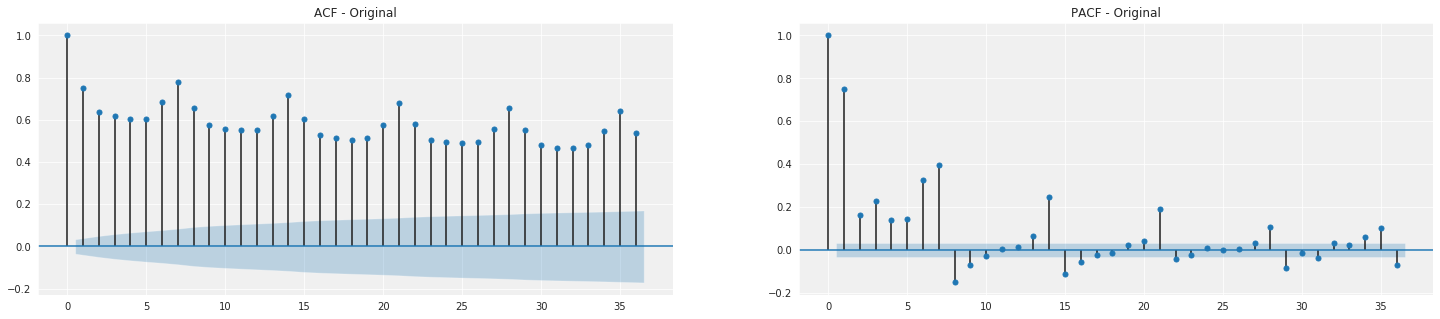

In [0]:
plt.rcParams.update({'figure.figsize':(25,5)})
fig1, axes1 = plt.subplots(1, 2, sharex=True)
plot_acf(df, ax=axes1[0])
axes1[0].set_title('ACF - Original')
plot_pacf(df, ax=axes1[1])
axes1[1].set_title('PACF - Original')
plt.show()

visti la discesa dei ritardi nel ACF e PACF, che suggeriscono una periodicità 7, sia nella parte AR che MA, e vista la diff precedente, si opta per partire con lo studio di un modello ARIMA (1,0,1)(1,1,1)7

In [0]:
model = SARIMAX(train, None, 1, 0, 1, 1, 1, 1, 7, reg='no')
print(model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                 2922
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood              -11926.183
Date:                           Mon, 27 Jan 2020   AIC                          23862.367
Time:                                   21:42:10   BIC                          23892.239
Sample:                               01-01-2010   HQIC                         23873.129
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9387      0.008    123.260      0.000       0.924       0.954
ma.L1         -0.6171      0.014    -44.721

tutte le componenti risultano significative

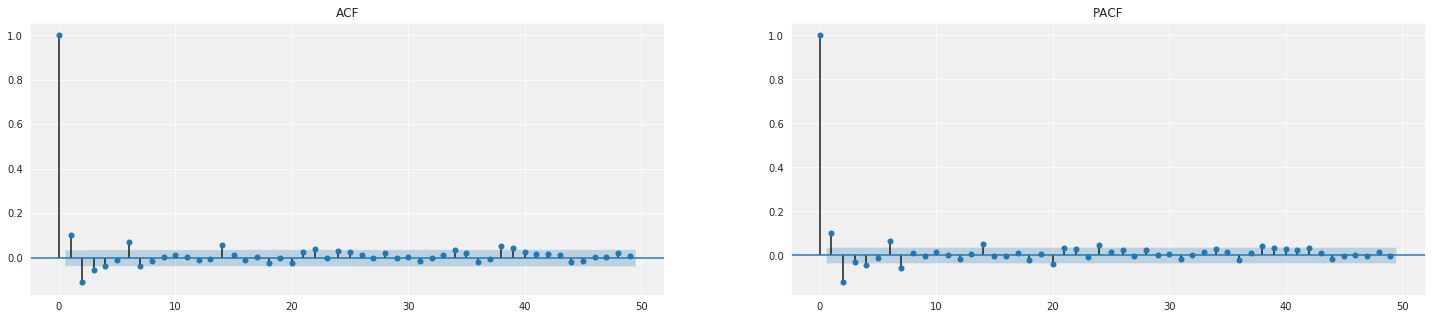

In [0]:
plot_ACF_PACF(model)

In [0]:
model = SARIMAX(train, None, 1, 1, 1, 1, 1, 1, 7, reg='no')
print(model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                 2922
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -11903.380
Date:                           Mon, 27 Jan 2020   AIC                          23816.761
Time:                                   21:42:36   BIC                          23846.632
Sample:                               01-01-2010   HQIC                         23827.523
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2671      0.017     15.919      0.000       0.234       0.300
ma.L1         -0.8475      0.011    -80.175

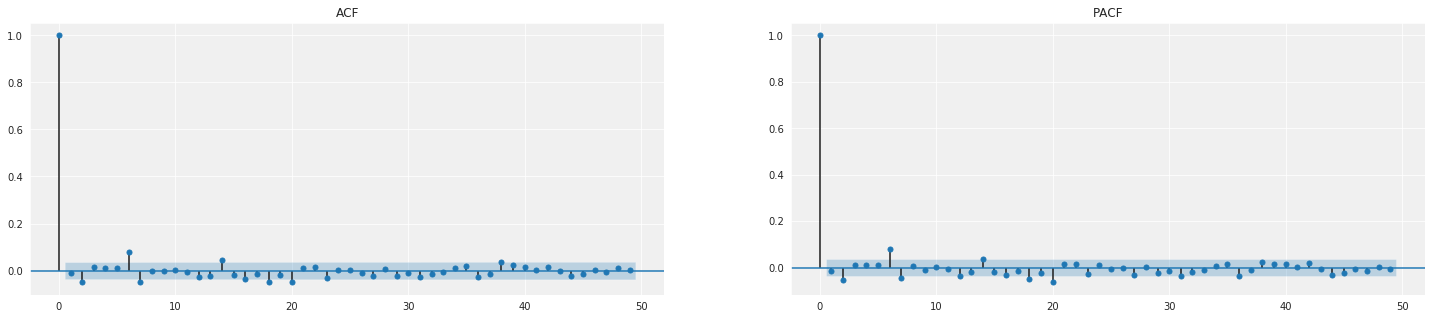

In [0]:
plot_ACF_PACF(model)

per determinare i migliori parametri non stagionali, AR(i) e MA(j), uso un approccio **grid search** per identificarli, andando a massimizzare la log-likelihood

In [0]:
best_logL = -999999
start = time.time()
for i in tqdm_notebook(range(7)):
  for j in range(7):
    model = SARIMAX(train, None, i, 1, j, 1, 1, 1, 7, reg = 'no')
    aic = model.aic
    bic = model.bic
    logL = model.llf
    if logL >= best_logL:
      best_logL = logL
      params = ((i,j))
    print('AR {} -- MA {},  AIC current: {}, BIC current: {} -- BEST LOG-LIKELIHOOD: {}, (ARMA {})'.format(i, j, round(aic, 2), round(bic, 2), round(best_logL, 2), params))
print('###############################################################')
stop = time.time() 
print('Execution Time: {}'.format(str(datetime.timedelta(seconds=round(stop-start, 2)))))
print('BEST AR {} -- MA {},  with LOG-LIKELIHOOD: {}'.format(params[0], params[1], best_logL))

AR 0 -- MA 0,  AIC current: 24710.46, BIC current: 24728.38 -- BEST LOG-LIKELIHOOD: -12352.23, (ARMA (0, 0))
AR 0 -- MA 1,  AIC current: 23916.83, BIC current: 23940.73 -- BEST LOG-LIKELIHOOD: -11954.42, (ARMA (0, 1))
AR 0 -- MA 2,  AIC current: 23808.68, BIC current: 23838.55 -- BEST LOG-LIKELIHOOD: -11899.34, (ARMA (0, 2))
AR 0 -- MA 3,  AIC current: 23801.8, BIC current: 23837.64 -- BEST LOG-LIKELIHOOD: -11894.9, (ARMA (0, 3))
AR 0 -- MA 4,  AIC current: 23790.21, BIC current: 23832.03 -- BEST LOG-LIKELIHOOD: -11888.11, (ARMA (0, 4))
AR 0 -- MA 5,  AIC current: 23782.22, BIC current: 23830.01 -- BEST LOG-LIKELIHOOD: -11883.11, (ARMA (0, 5))
AR 0 -- MA 6,  AIC current: 23768.58, BIC current: 23822.33 -- BEST LOG-LIKELIHOOD: -11875.29, (ARMA (0, 6))
AR 1 -- MA 0,  AIC current: 24342.88, BIC current: 24366.78 -- BEST LOG-LIKELIHOOD: -11875.29, (ARMA (0, 6))
AR 1 -- MA 1,  AIC current: 23816.76, BIC current: 23846.63 -- BEST LOG-LIKELIHOOD: -11875.29, (ARMA (0, 6))
AR 1 -- MA 2,  AIC cu

In [0]:
model = SARIMAX(train, None, 6, 1, 6, 1, 1, 1, 7, reg='no')
print(model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                 2922
Model:             SARIMAX(6, 1, 6)x(1, 1, 1, 7)   Log Likelihood              -11851.410
Date:                           Mon, 27 Jan 2020   AIC                          23732.820
Time:                                   21:58:48   BIC                          23822.407
Sample:                               01-01-2010   HQIC                         23765.100
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7232      0.105     -6.874      0.000      -0.929      -0.517
ar.L2         -0.3985      0.143     -2.785

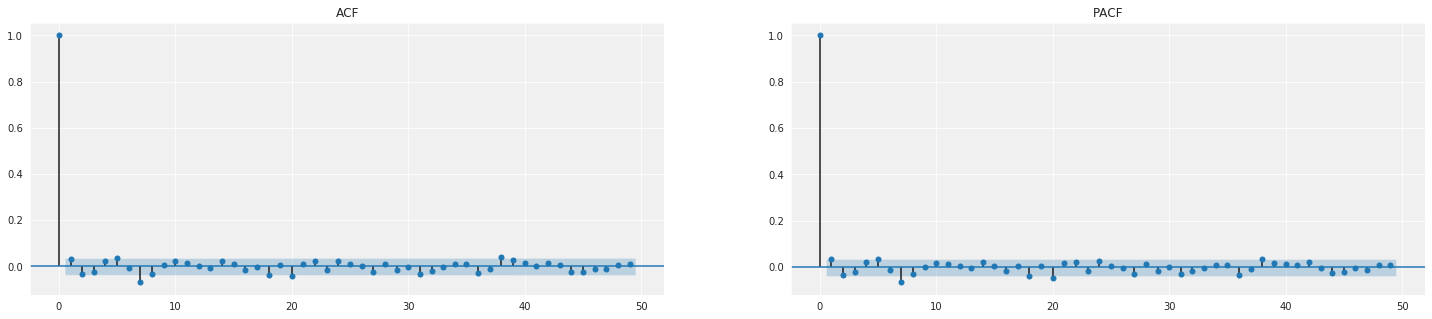

In [0]:
plot_ACF_PACF(model)

possiamo vedere dai ritardi, come siano stati modellati per bene 

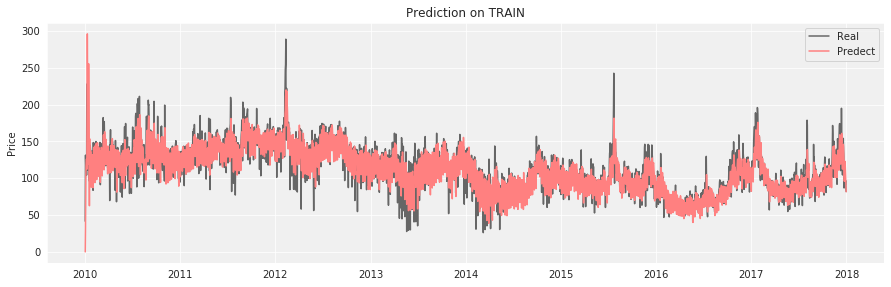

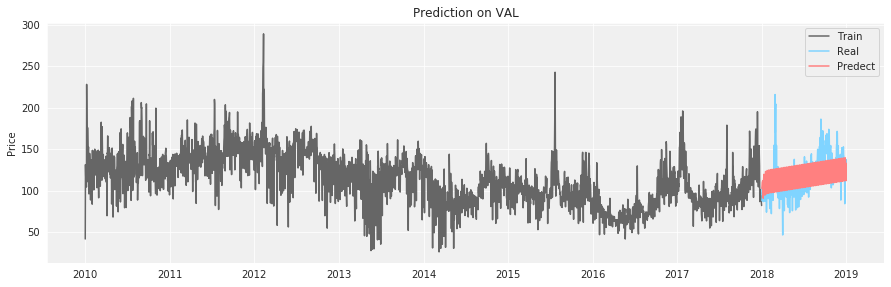

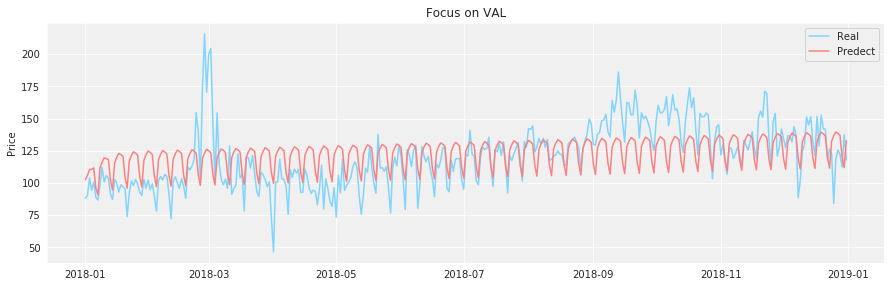

MAPE Train: 9.785313999565744
MAPE Validation: 13.857234338988814


In [0]:
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
plot_PREDICTION(train, val, pred_train, pred_val)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

Si verifica ora un miglioramento del modello, inserendo i regressori creati precedentmente 

In [0]:
print('<<<<<<<<<<  Senza Regressori  <<<<<<<<<<'+'\n')
model = SARIMAX(train, None, 6, 1, 6, 1, 1, 1, 7, reg='no')
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

print('\n<<<<<<<<<<  REG - Feste  <<<<<<<<<<'+'\n')
model = SARIMAX(train, REG_FESTE_train, 6, 1, 6, 1, 1, 1, 7, reg='yes')
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, REG_FESTE_train, REG_FESTE_val, exog = 1)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

print('\n<<<<<<<<<<  REG - Freq  <<<<<<<<<<'+'\n')
model = SARIMAX(train, REG_FREQ_train, 6, 1, 6, 1, 1, 1, 7, reg='yes')
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, REG_FREQ_train, REG_FREQ_val, exog = 1)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

print('\n<<<<<<<<<<  REG - Feste + Freq  <<<<<<<<<<'+'\n')
model = SARIMAX(train, REG_FESTE_FREQ_train, 6, 1, 6, 1, 1, 1, 7, reg='yes')
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, REG_FESTE_FREQ_train, REG_FESTE_FREQ_val, exog = 1)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

<<<<<<<<<<  Senza Regressori  <<<<<<<<<<

MAPE Train: 9.785313999565744
MAPE Validation: 13.857234338988814

<<<<<<<<<<  REG - Feste  <<<<<<<<<<

MAPE Train: 9.782285943979293
MAPE Validation: 13.828366756108274

<<<<<<<<<<  REG - Freq  <<<<<<<<<<

MAPE Train: 9.797123565663357
MAPE Validation: 13.877569482538457

<<<<<<<<<<  REG - Feste + Freq  <<<<<<<<<<

MAPE Train: 9.261652205970952
MAPE Validation: 14.41084720087986


è possibile vedere come il modello con regressori relativi alle feste sia il migliore

### Modello ARIMA Finale

verifichiamo graficamente le previsizoni sul training e validation

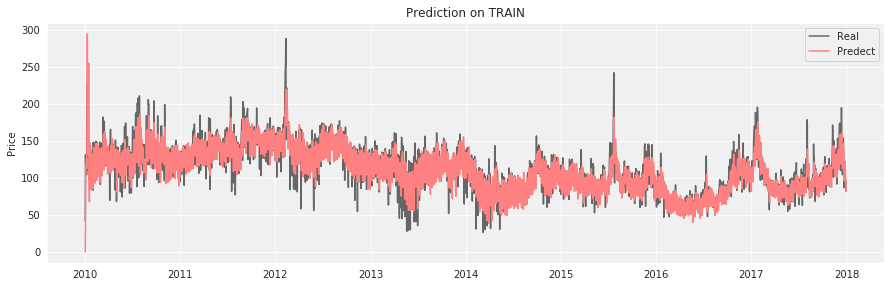

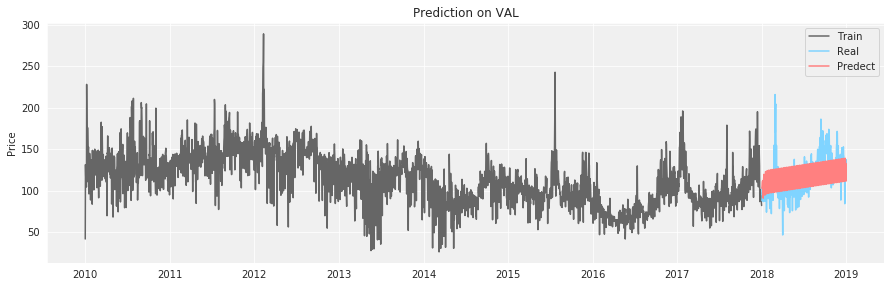

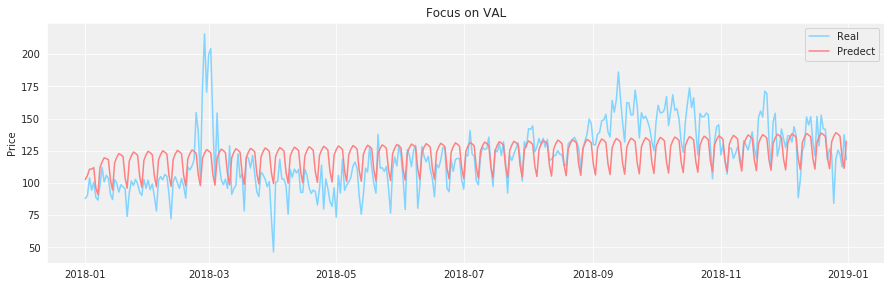

MAPE Train: 9.782285943979293
MAPE Validation: 13.828366756108274


In [0]:
model_ARIMA = SARIMAX(train, REG_FESTE_train, 6, 1, 6, 1, 1, 1, 7, reg='yes')
pred_train_ARIMA, pred_val_ARIMA  = prediction_SARIMAX_UCM(model_ARIMA, train, val, REG_FESTE_train, REG_FESTE_val, exog = 1)
plot_PREDICTION(train, val, pred_train_ARIMA, pred_val_ARIMA)
mape_train_ARIMA, mape_val_ARIMA = error_eval(mean_absolute_percentage_error, pred_train_ARIMA, pred_val_ARIMA, verbose = 1)

## UCM

---



Per il modello UCM inizio con l'analisi di un modello con livello *local level*, stagionalità stocastica settimanale dummy e ciclo

In [0]:
model = sm.tsa.UnobservedComponents(train, 'llevel', 
                                        cycle = True, seasonal=7,
                                        stochastic_seasonal=True)  
                                                  
model = model.fit()
print(model.summary())

                           Unobserved Components Results                            
Dep. Variable:                        value   No. Observations:                 2922
Model:                          local level   Log Likelihood              -12031.879
                   + stochastic seasonal(7)   AIC                          24071.758
                                    + cycle   BIC                          24095.666
Date:                      Mon, 27 Jan 2020   HQIC                         24080.370
Time:                              22:09:35                                         
Sample:                          01-01-2010                                         
                               - 12-31-2017                                         
Covariance Type:                        opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

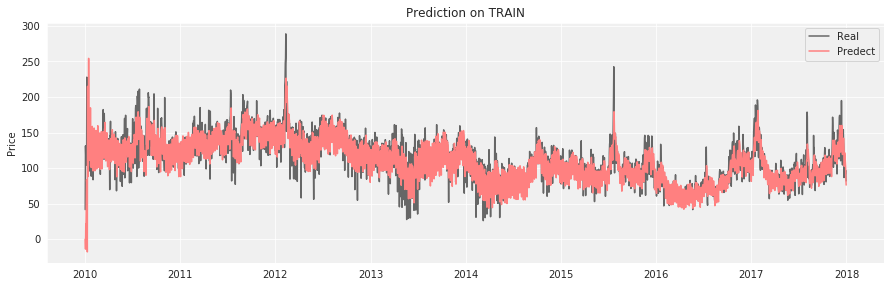

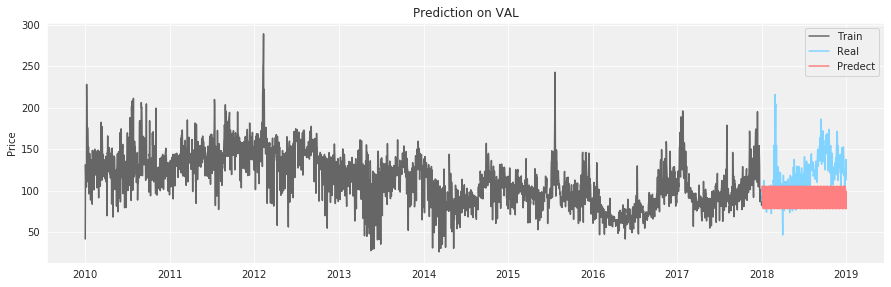

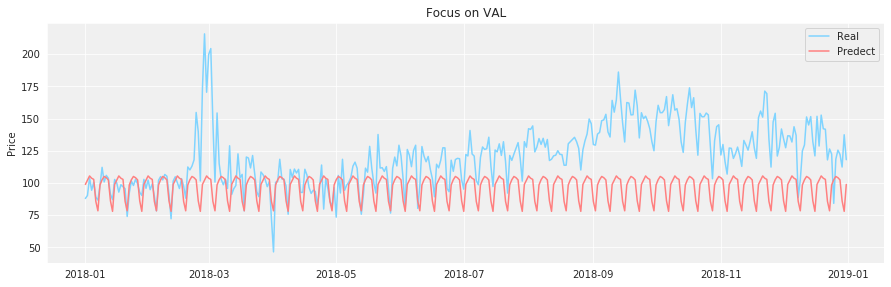

MAPE Train: 10.290948754301132
MAPE Validation: 19.442412395883704


In [0]:
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
plot_PREDICTION(train, val, pred_train, pred_val)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

come in precedenza, tramite **grid search** verifico quale trend ha una performance (in MAPE) migliore sul modello

In [0]:
levels = ['ntrend', 'dconstant', 'llevel', 'rwalk', 'lldtrend', 'rwdrift', 'lltrend', 'strend', 'rtrend']

best = 99999
start = time.time()
for level in tqdm_notebook(levels):
  model = sm.tsa.UnobservedComponents(train, level, 
                                        cycle = True, seasonal=7, #freq_seasonal = [{'period':30, 'harmonics':12}],
                                        stochastic_seasonal=True)
  model = model.fit()  
  pred_ucm_train, pred_ucm_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
  mape_ucm_train, mape_ucm_val  = error_eval(mean_absolute_percentage_error, pred_ucm_train, pred_ucm_val)
  if mape_ucm_val+mape_ucm_train <= best:
    best = mape_ucm_val+mape_ucm_train
    best_mape_train = mape_ucm_train
    best_mape_val = mape_ucm_val
    best_level = level
  print('Level: {},  MAPE on Train: {}, MAPE on Val: {} -- BEST: {}'.format(level, round(mape_ucm_train, 2), round(mape_ucm_val, 2), round(best, 2)))
  
print('###############################################################')
stop = time.time() 
print('Execution Time: {}'.format(str(datetime.timedelta(seconds=round(stop-start, 2)))))
print('BEST Level: {},  with MAPE on Train: {}, MAPE on Val: {}'.format(best_level, best_mape_train, best_mape_val))

Level: ntrend,  MAPE on Train: 102.6, MAPE on Val: 100.77 -- BEST: 203.36
Level: dconstant,  MAPE on Train: 25.54, MAPE on Val: 15.27 -- BEST: 40.82
Level: llevel,  MAPE on Train: 10.29, MAPE on Val: 19.44 -- BEST: 29.73
Level: rwalk,  MAPE on Train: 11.1, MAPE on Val: 17.63 -- BEST: 28.73
Level: lldtrend,  MAPE on Train: 10.36, MAPE on Val: 19.94 -- BEST: 28.73
Level: rwdrift,  MAPE on Train: 11.07, MAPE on Val: 15.31 -- BEST: 26.38
Level: lltrend,  MAPE on Train: 13.78, MAPE on Val: 723.65 -- BEST: 26.38
Level: strend,  MAPE on Train: 10.88, MAPE on Val: 469.76 -- BEST: 26.38
Level: rtrend,  MAPE on Train: 15.19, MAPE on Val: 610.2 -- BEST: 26.38
###############################################################
Execution Time: 0:00:17.960000
BEST Level: rwdrift,  with MAPE on Train: 11.066888825351894, MAPE on Val: 15.31366042053564


continuo quindi con level = random walk con drift

                           Unobserved Components Results                            
Dep. Variable:                        value   No. Observations:                 2922
Model:               random walk with drift   Log Likelihood              -12405.157
                   + stochastic seasonal(7)   AIC                          24816.314
                                    + cycle   BIC                          24834.244
Date:                      Mon, 27 Jan 2020   HQIC                         24822.774
Time:                              22:17:12                                         
Sample:                          01-01-2010                                         
                               - 12-31-2017                                         
Covariance Type:                        opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

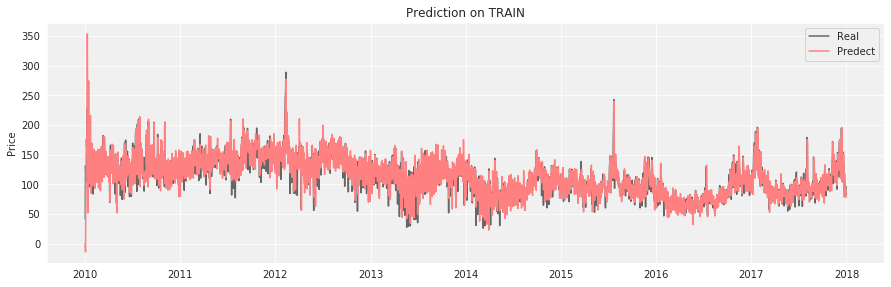

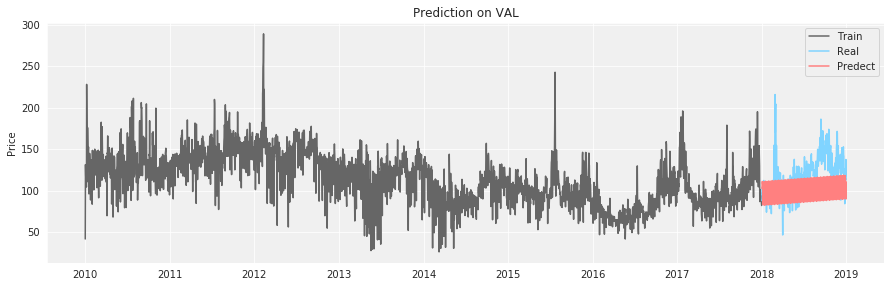

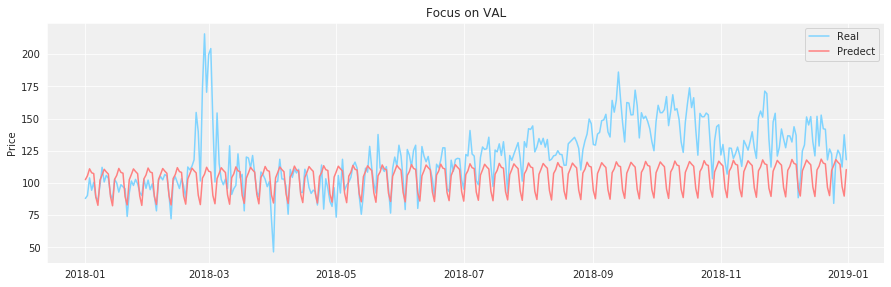

MAPE Train: 11.066888825351894
MAPE Validation: 15.31366042053564


In [0]:
model = sm.tsa.UnobservedComponents(train, 'rwdrift', 
                                        cycle = True, seasonal=7,
                                        stochastic_seasonal=True)  
                                                  
model = model.fit()
print(model.summary())
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
plot_PREDICTION(train, val, pred_train, pred_val)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

testo ora alcune configurazioni di stagionalità differenti (sia dummy che trigonometriche)

In [0]:
print('<<<<<<<<<<  Ciclo + Stagionalità 7 (dummy)  <<<<<<<<<<'+'\n')
model = sm.tsa.UnobservedComponents(train, 'rwdrift', 
                                        cycle = True, seasonal = 7,
                                        stochastic_seasonal=True)                                                    
model = model.fit()
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

print('\n<<<<<<<<<<  Ciclo + Stagionalità 7 (dummy), 30 (trig, 12 armoniche)  <<<<<<<<<<'+'\n')
model = sm.tsa.UnobservedComponents(train, 'rwdrift', 
                                        cycle = True, seasonal = 7, freq_seasonal = [{'period':30, 'harmonics':12}],
                                        stochastic_seasonal=True)                                                    
model = model.fit()
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

print('\n<<<<<<<<<<  Stagionalità 7 (dummy), 30 (trig, 12 armoniche), 365 (trig, 24 armoniche)  <<<<<<<<<<'+'\n')
model = sm.tsa.UnobservedComponents(train, 'rwdrift', 
                                        cycle = False, seasonal = 7, freq_seasonal = [{'period':30, 'harmonics':12}, {'period':365, 'harmonics':24}],
                                        stochastic_seasonal=True)                                                    
model = model.fit()
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

print('\n<<<<<<<<<<  Ciclo + Stagionalità 7 (dummy), 30 (trig, 12 armoniche), 365 (trig, 24 armoniche)  <<<<<<<<<<'+'\n')
model = sm.tsa.UnobservedComponents(train, 'rwdrift', 
                                        cycle = True, seasonal = 7, freq_seasonal = [{'period':30, 'harmonics':12}, {'period':365, 'harmonics':24}],
                                        stochastic_seasonal=True)                                                    
model = model.fit()
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

print('\n<<<<<<<<<<  Ciclo + Stagionalità 7 (dummy), 365 (trig, 24 armoniche)  <<<<<<<<<<'+'\n')
model = sm.tsa.UnobservedComponents(train, 'rwdrift', 
                                        cycle = True, seasonal = 7, freq_seasonal = [{'period':365, 'harmonics':24}],
                                        stochastic_seasonal=True)                                                    
model = model.fit()
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

<<<<<<<<<<  Ciclo + Stagionalità 7 (dummy)  <<<<<<<<<<

MAPE Train: 11.066888825351894
MAPE Validation: 15.31366042053564

<<<<<<<<<<  Ciclo + Stagionalità 7 (dummy), 30 (trig, 12 armoniche)  <<<<<<<<<<

MAPE Train: 14.351788958259712
MAPE Validation: 16.320463172428607

<<<<<<<<<<  Stagionalità 7 (dummy), 30 (trig, 12 armoniche), 365 (trig, 24 armoniche)  <<<<<<<<<<

MAPE Train: 17.097220524014666
MAPE Validation: 16.168459531044515

<<<<<<<<<<  Ciclo + Stagionalità 7 (dummy), 30 (trig, 12 armoniche), 365 (trig, 24 armoniche)  <<<<<<<<<<

MAPE Train: 17.098776449177013
MAPE Validation: 16.15540005466363

<<<<<<<<<<  Ciclo + Stagionalità 7 (dummy), 365 (trig, 24 armoniche)  <<<<<<<<<<

MAPE Train: 13.027431506752194
MAPE Validation: 14.947789866414753


Il migliore risulta l'ultimo modello (migliora in val leggermente, peggiora in train); segue una valutazione grafica

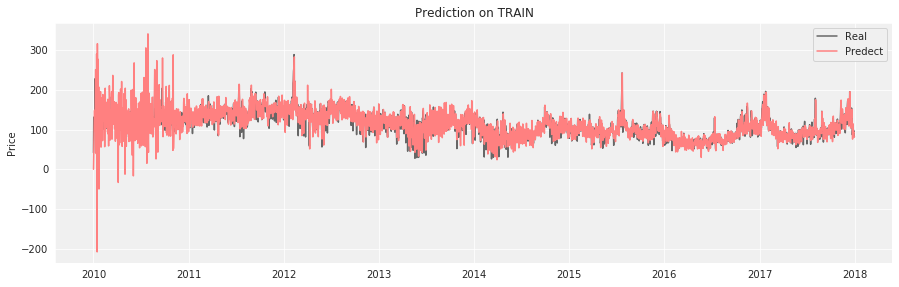

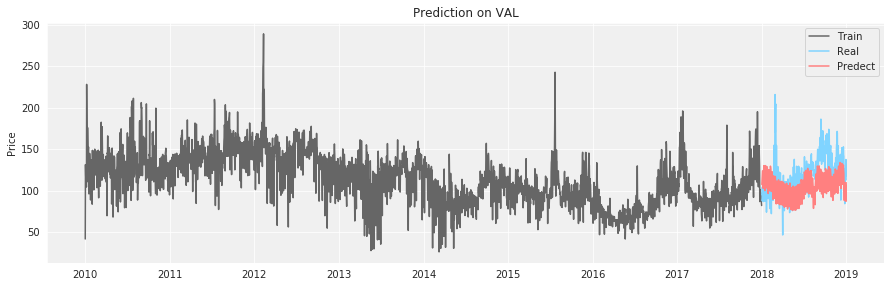

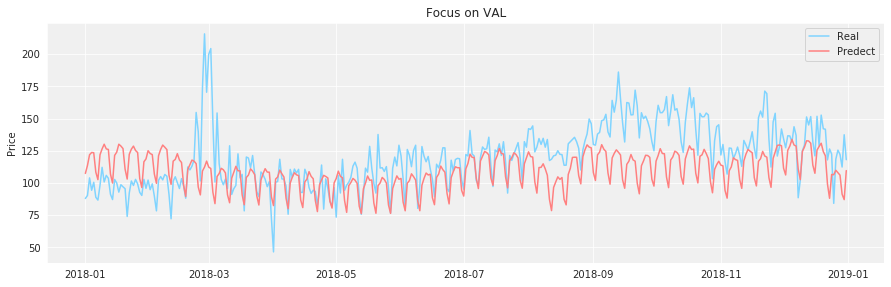

MAPE Train: 13.027431506752194
MAPE Validation: 14.947789866414753


In [0]:
model = sm.tsa.UnobservedComponents(train, 'rwdrift', 
                                        cycle = True, seasonal = 7, freq_seasonal = [{'period':365, 'harmonics':24}],
                                        stochastic_seasonal=True)                                                    
model = model.fit()
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
plot_PREDICTION(train, val, pred_train, pred_val)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

sembra catturare meglio l'andamento degli ultimi anni, meglio del modello precedente.

Come fatto in precednza verifico l'inserimento di regressori esterni anche su questo modello

In [0]:
print('<<<<<<<<<<  Senza Regressori  <<<<<<<<<<'+'\n')
model = sm.tsa.UnobservedComponents(train, 'rwdrift', 
                                        cycle = True, seasonal = 7, freq_seasonal = [{'period':365, 'harmonics':24}],
                                        stochastic_seasonal=True)                                                    
model = model.fit()
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, None, None, exog = 0)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

print('\n<<<<<<<<<<  REG - Feste  <<<<<<<<<<'+'\n')
model = sm.tsa.UnobservedComponents(train, 'rwdrift', exog = REG_FESTE_train,
                                        cycle = True, seasonal = 7, freq_seasonal = [{'period':365, 'harmonics':24}],
                                        stochastic_seasonal=True)                                                    
model = model.fit()
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, REG_FESTE_train, REG_FESTE_val, exog = 1)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

print('\n<<<<<<<<<<  REG - Freq  <<<<<<<<<<'+'\n')
model = sm.tsa.UnobservedComponents(train, 'rwdrift', exog = REG_FREQ_train,
                                        cycle = True, seasonal = 7,  freq_seasonal = [{'period':365, 'harmonics':24}],
                                        stochastic_seasonal=True)                                                    
model = model.fit()
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, REG_FREQ_train, REG_FREQ_val, exog = 1)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

print('\n<<<<<<<<<<  REG - Feste + Freq  <<<<<<<<<<'+'\n')
model = sm.tsa.UnobservedComponents(train, 'rwdrift', exog = REG_FESTE_FREQ_train,
                                        cycle = True, seasonal = 7,  freq_seasonal = [{'period':365, 'harmonics':24}],
                                        stochastic_seasonal=True)                                                    
model = model.fit()
pred_train, pred_val  = prediction_SARIMAX_UCM(model, train, val, REG_FESTE_FREQ_train, REG_FESTE_FREQ_val, exog = 1)
mape_train, mape_val = error_eval(mean_absolute_percentage_error, pred_train, pred_val, verbose = 1)

<<<<<<<<<<  Senza Regressori  <<<<<<<<<<

MAPE Train: 13.027431506752194
MAPE Validation: 14.947789866414753

<<<<<<<<<<  REG - Feste  <<<<<<<<<<

MAPE Train: 12.376186106629012
MAPE Validation: 16.676078710323402

<<<<<<<<<<  REG - Freq  <<<<<<<<<<

MAPE Train: 13.138122721545887
MAPE Validation: 16.69446881229503

<<<<<<<<<<  REG - Feste + Freq  <<<<<<<<<<

MAPE Train: 12.344929344737286
MAPE Validation: 16.223932580784517


Non risultano miglioramenti.

### Modello UCM Finale

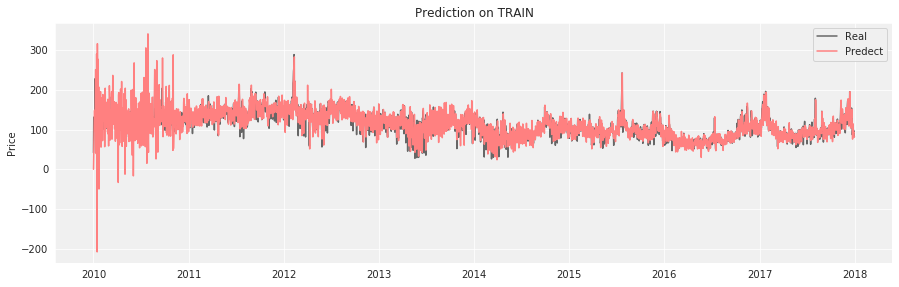

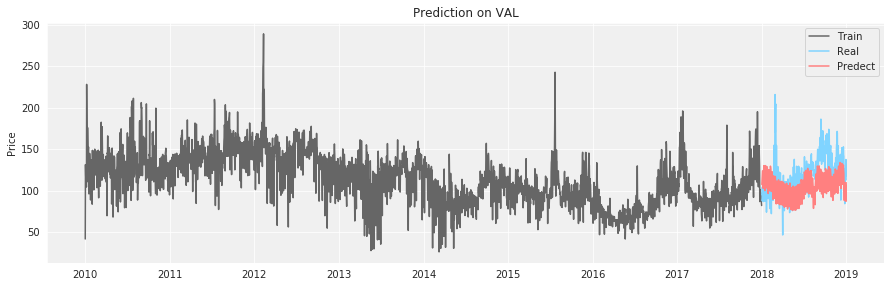

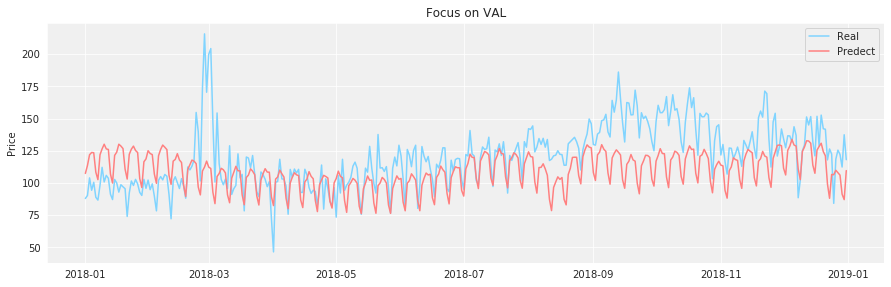

MAPE Train: 13.027431506752194
MAPE Validation: 14.947789866414753


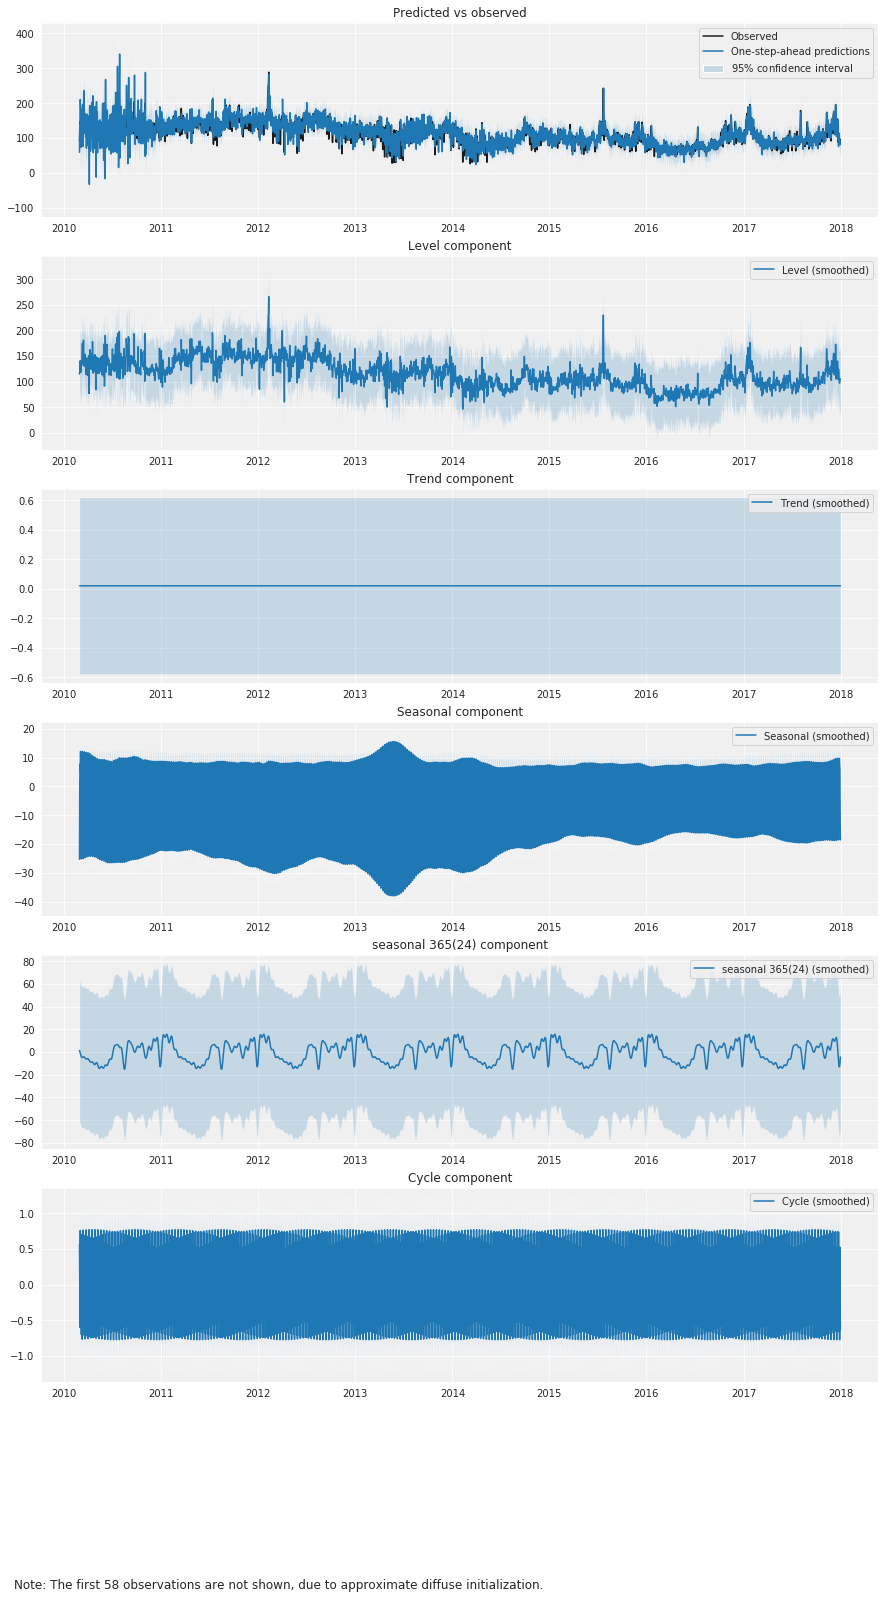

In [0]:
model_UCM = sm.tsa.UnobservedComponents(train, 'rwdrift', 
                                        cycle = True, seasonal = 7, freq_seasonal = [{'period':365, 'harmonics':24}],
                                        stochastic_seasonal=True)                                                    
model_UCM = model_UCM.fit()
pred_train_UCM, pred_val_UCM  = prediction_SARIMAX_UCM(model_UCM, train, val, None, None, exog = 0)
plot_PREDICTION(train, val, pred_train_UCM, pred_val_UCM)
mape_train_UCM, mape_val_UCM = error_eval(mean_absolute_percentage_error, pred_train_UCM, pred_val_UCM, verbose = 1)
fig = model_UCM.plot_components(figsize=(15, 25))
plt.show()

## RNN

---



Inifne per i modelli relativi al machine learning, valuto due archityetture GRU e LSTM.

Definisco in primis l'architettura (condivisa se non per il primo layer)

In [0]:
def create_model_RNN(look_back, layer, summary = 0):
  K.clear_session()
  model = Sequential()
  if layer == 'GRU':
    model.add(CuDNNGRU(256, input_shape = (1, look_back)))#, kernel_regularizer = l1(0.001), activity_regularizer = l1(0.001)))
  elif layer == 'LSTM':
    model.add(CuDNNLSTM(256, input_shape = (1, look_back)))#, kernel_regularizer = l1(0.001), activity_regularizer = l1(0.001)))
  model.add(LeakyReLU())
  model.add(Dropout(0.33))
  model.add(BatchNormalization())
  #model.add(GRU(100, activation = 'tanh', return_sequences = False, kernel_regularizer = l1(0.001), activity_regularizer = l1(0.001)))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.33))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss='mse', optimizer = Adam(), metrics=['mape'])
  if summary == 1:
    model.summary()
  return model

Scalo i dati tra 0.001 e 1 (con un numero più vicno a zero c'è il problema del MAPE sul training, col fatto che vengono valutati valori reali vs predetti, con i primi che potrebbero essere stati scalati appunto a zero, non compatibile con questa metrica)

In [0]:
scaler = MinMaxScaler(feature_range=(0.001, 1)).fit(train.values.reshape(-1,1))

trainNormalized = scaler.transform(train.values.reshape(-1 , 1))
valNormalized = scaler.transform(val.values.reshape(-1 , 1))

In [0]:
np.max(trainNormalized), np.min(trainNormalized)

(1.0, 0.0010000000000000009)

scelgo come finsetra look_back, che guarda indetro sulla sere pari a 365 (1 anno, come la futura predizione da fare sul validation)

In [0]:
window = 365
x, y = create_timeSeries(trainNormalized, window)
#xval, yval = create_timeSeries(valNormalized, window)

**GRU**

---



In [0]:
create_model_RNN(look_back = window, layer = 'GRU', summary=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 256)               478464    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

tramite ModelCheckpoint monitoro e salvo il modello migliore che minimizza di più il MAPE in training, non avendo a disposizione un validation (potrebbe essere utilizzato, aumentando lo split della sere iniziale, es. 7 anni - 2 anni, con finsetra di 1 anno...ma preferisco avere più dati e meno controllo sull'addestramento; viene comunque implementate una pipe per la selezione del modello in base anche alla performance del medesimo sul validation)

>>>>>>>>>>  Step 1/5
MAPE VAl current: 15.5 -- MAPE VAL BEST: 15.5
>>>>>>>>>>  Step 2/5
MAPE VAl current: 13.32 -- MAPE VAL BEST: 13.32
>>>>>>>>>>  Step 3/5
MAPE VAl current: 13.41 -- MAPE VAL BEST: 13.32
>>>>>>>>>>  Step 4/5
MAPE VAl current: 15.52 -- MAPE VAL BEST: 13.32
>>>>>>>>>>  Step 5/5
MAPE VAl current: 14.77 -- MAPE VAL BEST: 13.32

Execution Time: 0:02:26.220000


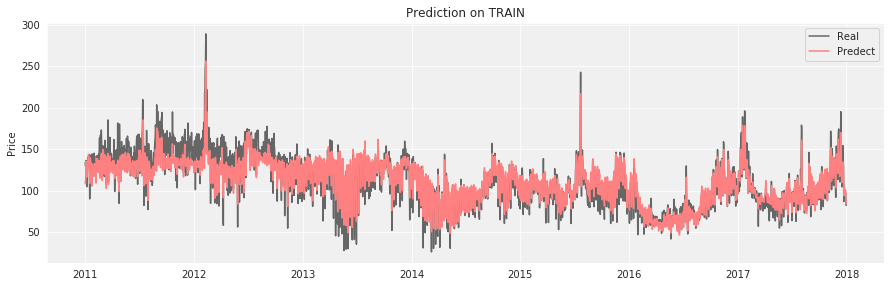

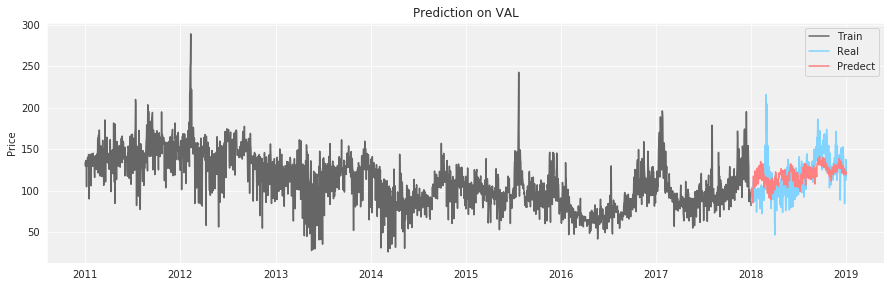

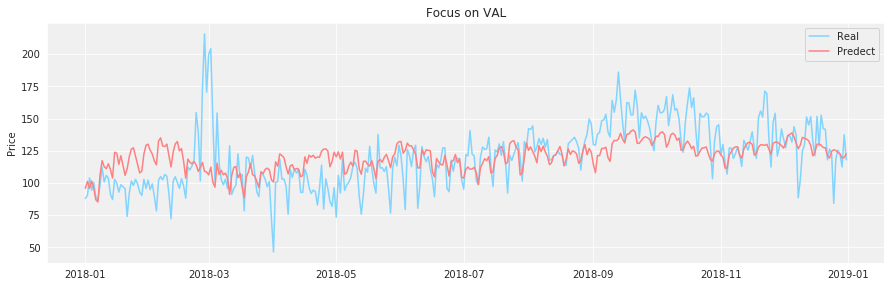

MAPE Train: 8.650046769751562
MAPE Validation: 13.321635416767197


In [0]:
start = time.time()
step = 5
BEST = 9999
pathBEST = '/content/gdrive/My Drive/Colab Notebooks/SDMTSA/Models/RNN-GRU-BEST.h5'
for i in tqdm_notebook(range(step)):
  print('>>>>>>>>>>  Step {}/{}'.format(i+1, step))
  filepath_gru = '/content/gdrive/My Drive/Colab Notebooks/SDMTSA/Models/RNN-GRU.h5'
  check = ModelCheckpoint(filepath_gru, monitor = 'mean_absolute_percentage_error', mode='min', save_best_only=True)
  callback_list = [check]

  model = create_model_RNN(look_back = window, layer = 'GRU')
  history = model.fit(x.reshape(-1, 1, x.shape[1]), y.reshape(-1,1), epochs=500, 
                      shuffle=False, #validation_data=(xval.reshape(-1, 1, xval.shape[1]), yval.reshape(-1,1)),
                      verbose=0, batch_size = 512, callbacks = callback_list)

  #model_plot(history.history, flag_NOvalidation = 1)

  model.load_weights(filepath_gru)
  pred_train = prediction_RNN(model, trainNormalized, look_back=window, window_pred=len(train)-window, index=train[window:].index, val_data=0)
  pred_val = prediction_RNN(model, trainNormalized, look_back=window, window_pred=365, index=val.index)
  mape_train, mape_val  = error_eval(mean_absolute_percentage_error, pred_train, pred_val, base = 'ML', window = window, verbose=0)
  if mape_val <= BEST:
    model.save(pathBEST)
    BEST = mape_val
  print('MAPE VAl current: {} -- MAPE VAL BEST: {}'.format(round(mape_val, 2), round(BEST, 2)))

stop = time.time() 
print('\nExecution Time: {}'.format(str(datetime.timedelta(seconds=round(stop-start, 2)))))
model.load_weights(pathBEST)
pred_train = prediction_RNN(model, trainNormalized, look_back=window, window_pred=len(train)-window, index=train[window:].index, val_data=0)
pred_val = prediction_RNN(model, trainNormalized, look_back=window, window_pred=365, index=val.index)
plot_PREDICTION(train[window:], val, pred_train, pred_val)
mape_train, mape_val  = error_eval(mean_absolute_percentage_error, pred_train, pred_val, base = 'ML', window = window, verbose=1)

**LSTM**

---



In [0]:
create_model_RNN(look_back = window, layer = 'LSTM', summary=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               637952    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

>>>>>>>>>>  Step 1/5
MAPE VAl current: 16.05 -- MAPE VAL BEST: 16.05
>>>>>>>>>>  Step 2/5
MAPE VAl current: 13.5 -- MAPE VAL BEST: 13.5
>>>>>>>>>>  Step 3/5
MAPE VAl current: 14.74 -- MAPE VAL BEST: 13.5
>>>>>>>>>>  Step 4/5
MAPE VAl current: 15.05 -- MAPE VAL BEST: 13.5
>>>>>>>>>>  Step 5/5
MAPE VAl current: 15.22 -- MAPE VAL BEST: 13.5

Execution Time: 0:02:40.610000


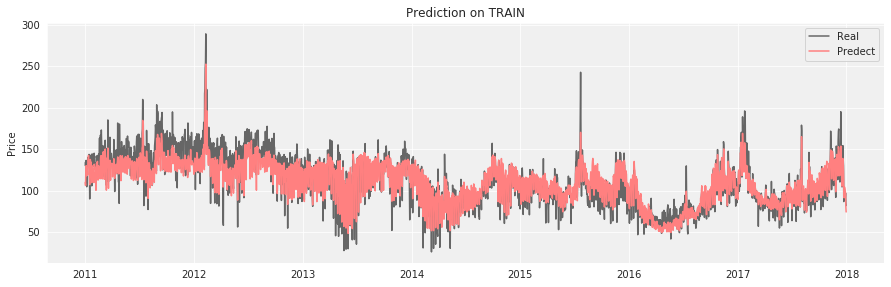

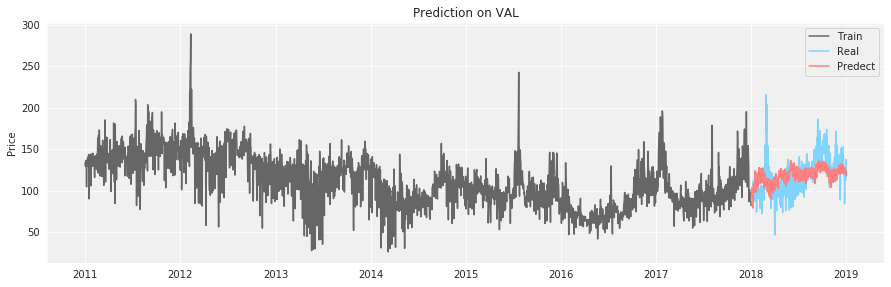

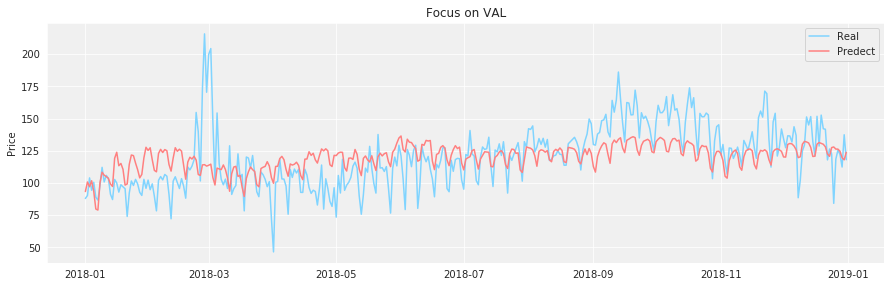

MAPE Train: 9.774944204057011
MAPE Validation: 13.499660970939475


In [0]:
start = time.time()
step = 5
BEST = 9999
pathBEST = '/content/gdrive/My Drive/Colab Notebooks/SDMTSA/Models/RNN-LSTM-BEST.h5'
for i in tqdm_notebook(range(step)):
  print('>>>>>>>>>>  Step {}/{}'.format(i+1, step))
  filepath_lstm = '/content/gdrive/My Drive/Colab Notebooks/SDMTSA/Models/RNN-LSTM.h5'
  check = ModelCheckpoint(filepath_lstm, monitor = 'mean_absolute_percentage_error', mode='min', save_best_only=True)
  callback_list = [check]

  model = create_model_RNN(look_back = window, layer = 'LSTM')
  history = model.fit(x.reshape(-1, 1, x.shape[1]), y.reshape(-1,1), epochs=500, 
                      shuffle=False, #validation_data=(xval.reshape(-1, 1, xval.shape[1]), yval.reshape(-1,1)),
                      verbose=0, batch_size = 512, callbacks = callback_list)

  #model_plot(history.history, flag_NOvalidation = 1)

  model.load_weights(filepath_lstm)
  pred_train = prediction_RNN(model, trainNormalized, look_back=window, window_pred=len(train)-window, index=train[window:].index, val_data=0)
  pred_val = prediction_RNN(model, trainNormalized, look_back=window, window_pred=365, index=val.index)
  mape_train, mape_val  = error_eval(mean_absolute_percentage_error, pred_train, pred_val, base = 'ML', window = window, verbose=0)
  if mape_val <= BEST:
    model.save(pathBEST)
    BEST = mape_val
  print('MAPE VAl current: {} -- MAPE VAL BEST: {}'.format(round(mape_val, 2), round(BEST, 2)))

stop = time.time() 
print('\nExecution Time: {}'.format(str(datetime.timedelta(seconds=round(stop-start, 2)))))
model.load_weights(pathBEST)
pred_train = prediction_RNN(model, trainNormalized, look_back=window, window_pred=len(train)-window, index=train[window:].index, val_data=0)
pred_val = prediction_RNN(model, trainNormalized, look_back=window, window_pred=365, index=val.index)
plot_PREDICTION(train[window:], val, pred_train, pred_val)
mape_train, mape_val  = error_eval(mean_absolute_percentage_error, pred_train, pred_val, base = 'ML', window = window, verbose=1)

si puà vedere come le performance siano molto simili, scelgo GRU in quanto ha una complessità (numero di parametri) minore

### Modello RNN Finale

Continue on GRU

In [0]:
pathBEST = '/content/gdrive/My Drive/Colab Notebooks/SDMTSA/Models/RNN-GRU-BEST.h5'
model_GRU = create_model_RNN(look_back = window, layer = 'GRU')
model_GRU.load_weights(pathBEST)
pred_train_GRU = prediction_RNN(model_GRU, trainNormalized, look_back=window, window_pred=len(train)-window, index=train[window:].index, val_data=0)
pred_val_GRU = prediction_RNN(model_GRU, trainNormalized, look_back=window, window_pred=365, index=val.index)
#plot_PREDICTION(train[window:], val, pred_train_GRU, pred_val_GRU)
mape_train_GRU, mape_val_GRU  = error_eval(mean_absolute_percentage_error, pred_train_GRU, pred_val_GRU, base = 'ML', window = window, verbose=1)

MAPE Train: 8.650046769751562
MAPE Validation: 13.321635416767197


# Risultati 

---



Andiamo a confrontare i diversi risultati ottenuti

In [0]:
mape_train = [mape_train_ARIMA]
mape_train.append(mape_train_UCM)
mape_train.append(mape_train_GRU)

mape_val = [mape_val_ARIMA]
mape_val.append(mape_val_UCM)
mape_val.append(mape_val_GRU)

mape_train = pd.DataFrame(data = mape_train, index=['ARIMA', 'UCM', 'GRU'], columns=['MAPE Training'])
mape_val = pd.DataFrame(data = mape_val, index=['ARIMA', 'UCM', 'GRU'], columns=['MAPE Validation'])

results = pd.concat([mape_train, mape_val], axis=1)
results

,MAPE Training,MAPE Validation
ARIMA,9.782286,13.828367
UCM,13.027432,14.947790
GRU,8.650047,13.321635


## Addestramento Finale

---



viene infine creata la finta serie (da prevedere) come scopo del progetto, e riaddestrati tutti i modelli (con le configurazioni modellate) su tutti i dati a disposzione

In [0]:
series_forecast = pd.date_range(start='01-01-2019', end='30-11-2019')
ind = []
cat = []
for ptr in holidays.Italy(years = [2019]).items(): 
    ind.append(ptr[0])
    cat.append(ptr[1])
hol = pd.DataFrame(data=cat, index=ind)

temp = pd.concat((pd.DataFrame(series_forecast, index=series_forecast),hol), axis=1)
exog = pd.get_dummies(temp)
exog = exog.dropna()
REG_FESTE_FORECAST = exog.drop([0], axis=1) #0_Festa della Liberazione, Lunedì dell'Angelo to drop
#REG_FESTE_FORECAST = exog.set_index(series_forecast.index)
print(REG_FESTE_FORECAST.shape)
REG_FESTE_FORECAST.head(3)

(334, 12)


,0_Assunzione della Vergine,0_Capodanno,0_Epifania del Signore,0_Festa dei Lavoratori,0_Festa della Liberazione,0_Festa della Repubblica,0_Immacolata Concezione,0_Lunedì dell'Angelo,0_Natale,0_Pasqua di Resurrezione,0_Santo Stefano,0_Tutti i Santi
2019-01-01,0,1,0,0,0,0,0,0,0,0,0,0
2019-01-02,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-03,0,0,0,0,0,0,0,0,0,0,0,0


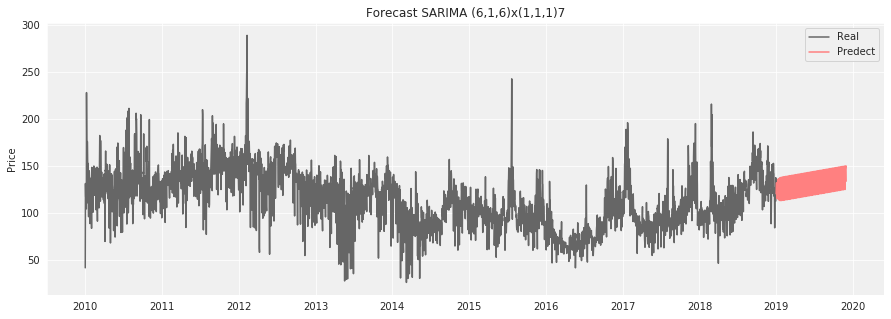

In [0]:
model_ARIMA_FINAL = SARIMAX(df, REG_FESTE, 6, 1, 6, 1, 1, 1, 7, reg='yes')
predicted_ARIMA_FINAL = model_ARIMA_FINAL.get_prediction(start=series_forecast[0], end=series_forecast[-1], exog = REG_FESTE_FORECAST)
predicted_ARIMA_FINAL = predicted_ARIMA_FINAL.predicted_mean
fig = plt.figure(figsize=(15,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Forecast SARIMA (6,1,6)x(1,1,1)7')
ax.plot(df, color='#666666', label='Real')
#ax.plot(val, color='#80d4ff', label='Real')
ax.plot(predicted_ARIMA_FINAL, color='#ff8080', label='Predect')
plt.ylabel('Price')
plt.legend()
plt.show()
#mape_train_ARIMA, mape_val_ARIMA = error_eval(mean_absolute_percentage_error, pred_train_ARIMA, pred_val_ARIMA, verbose = 1)

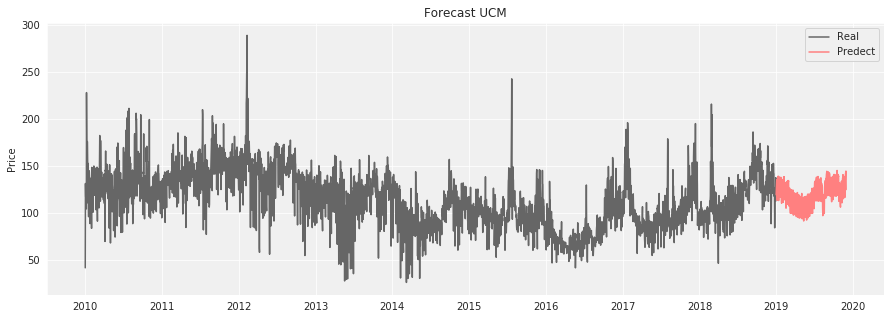

In [0]:
model_UCM_FINAL = sm.tsa.UnobservedComponents(df, 'rwdrift', 
                                        cycle = True, seasonal = 7, freq_seasonal = [{'period':365, 'harmonics':24}],
                                        stochastic_seasonal=True)                                                    
model_UCM_FINAL = model_UCM_FINAL.fit()
predicted_UCM_FINAL = model_UCM_FINAL.get_prediction(start=series_forecast[0], end=series_forecast[-1])
predicted_UCM_FINAL = predicted_UCM_FINAL.predicted_mean
fig = plt.figure(figsize=(15,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Forecast UCM')
ax.plot(df, color='#666666', label='Real')
#ax.plot(val, color='#80d4ff', label='Real')
ax.plot(predicted_UCM_FINAL, color='#ff8080', label='Predect')
plt.ylabel('Price')
plt.legend()
plt.show()
#mape_train_ARIMA, mape_val_ARIMA = error_eval(mean_absolute_percentage_error, pred_train_ARIMA, pred_val_ARIMA, verbose = 1)

In [0]:
scaler = MinMaxScaler(feature_range=(0.001, 1)).fit(df.values.reshape(-1,1))
dfNormalized = scaler.transform(df.values.reshape(-1 , 1))
window = 365
x, y = create_timeSeries(dfNormalized, window)

>>>>>>>>>>  Step 1/5
>>>>>>>>>>  Step 2/5
>>>>>>>>>>  Step 3/5
>>>>>>>>>>  Step 4/5
>>>>>>>>>>  Step 5/5

Execution Time: 0:01:47.120000


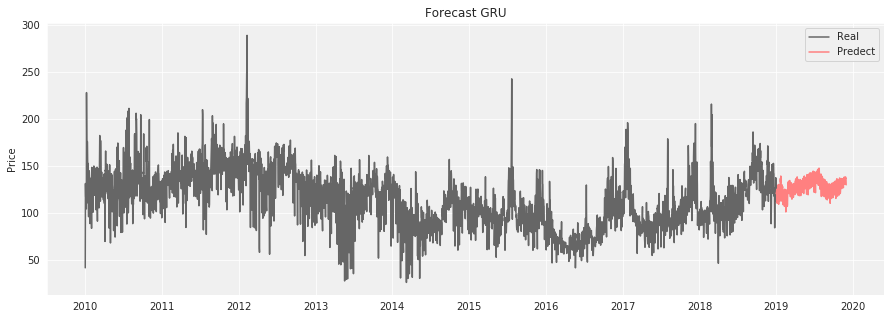

In [0]:
start = time.time()
step = 5
filepath_gru = '/content/gdrive/My Drive/Colab Notebooks/SDMTSA/Models/RNN-GRU-FORECAST.h5'
check = ModelCheckpoint(filepath_gru, monitor = 'mean_absolute_percentage_error', mode='min', save_best_only=True)
callback_list = [check]

for i in tqdm_notebook(range(step)):
  print('>>>>>>>>>>  Step {}/{}'.format(i+1, step))
  

  model_GRU_FINAL = create_model_RNN(look_back = window, layer = 'GRU')
  history = model_GRU_FINAL.fit(x.reshape(-1, 1, x.shape[1]), y.reshape(-1,1), epochs=500, 
                      shuffle=False, #validation_data=(xval.reshape(-1, 1, xval.shape[1]), yval.reshape(-1,1)),
                      verbose=0, batch_size = 512, callbacks = callback_list)

  #model_plot(history.history, flag_NOvalidation = 1)

model_GRU_FINAL.load_weights(filepath_gru)
  

stop = time.time() 
print('\nExecution Time: {}'.format(str(datetime.timedelta(seconds=round(stop-start, 2)))))
predicted_GRU_FINAL = prediction_RNN(model_GRU_FINAL, dfNormalized, look_back=window, window_pred=len(series_forecast), index=series_forecast)
fig = plt.figure(figsize=(15,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Forecast GRU')
ax.plot(df, color='#666666', label='Real')
#ax.plot(val, color='#80d4ff', label='Real')
ax.plot(predicted_GRU_FINAL, color='#ff8080', label='Predect')
plt.ylabel('Price')
plt.legend()
plt.show()
#mape_train_ARIMA, mape_val_ARIMA = error_eval(mean_absolute_percentage_error, pred_train_ARIMA, pred_val_ARIMA, verbose = 1)

## CSV Forecast

---



Realizzazione del csv comprendente le serie predette dai diversi modelli

In [0]:
df_forecast = pd.DataFrame(series_forecast, index = series_forecast)

forecast_models = pd.concat([df_forecast, predicted_ARIMA_FINAL, 
                                   predicted_UCM_FINAL, predicted_GRU_FINAL],axis=1)

forecast_models.columns = ['Data','ARIMA', 'UCM', 'ML']
forecast_models = forecast_models.reset_index().drop('index', axis=1)
forecast_models

,Data,ARIMA,UCM,ML
0,2019-01-01,120.281626,119.284170,120.543114
1,2019-01-02,131.781751,126.703216,121.419533
2,2019-01-03,132.040637,131.349016,122.387283
3,2019-01-04,132.098751,135.725511,125.219276
4,2019-01-05,121.768796,117.111977,113.825241
...,...,...,...,...
329,2019-11-26,146.668609,135.144631,138.138107
330,2019-11-27,148.852204,141.580078,138.353516
331,2019-11-28,149.763602,143.430023,136.716537
332,2019-11-29,150.129771,144.506185,137.084869


In [0]:
forecast_models.to_csv('/content/gdrive/My Drive/Colab Notebooks/SDMTSA/SDMTSA_847548_0.csv')

## Visualizzazione Forecast

---



In [0]:
forecast_models = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/SDMTSA/SDMTSA_847548_0.csv')

In [0]:
predicted_ARIMA_FINAL = pd.DataFrame(forecast_models.ARIMA)
predicted_ARIMA_FINAL.index = pd.to_datetime(forecast_models.Data)
predicted_UCM_FINAL = forecast_models.UCM
predicted_UCM_FINAL.index = pd.to_datetime(forecast_models.Data)
predicted_GRU_FINAL = forecast_models.ML
predicted_GRU_FINAL.index = pd.to_datetime(forecast_models.Data)

Vengono qui effettuate alcune visualzzazioni delle serie predette

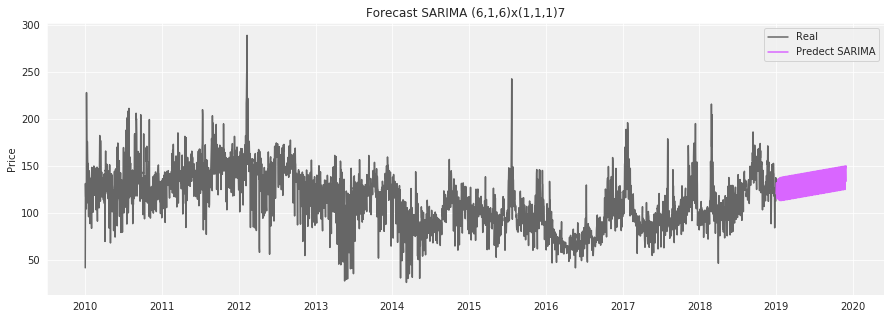

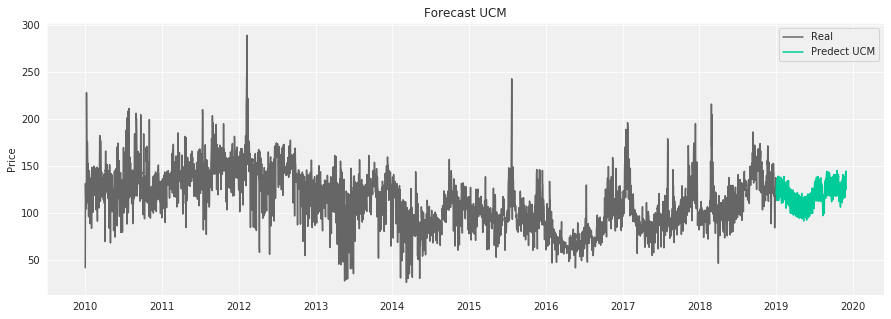

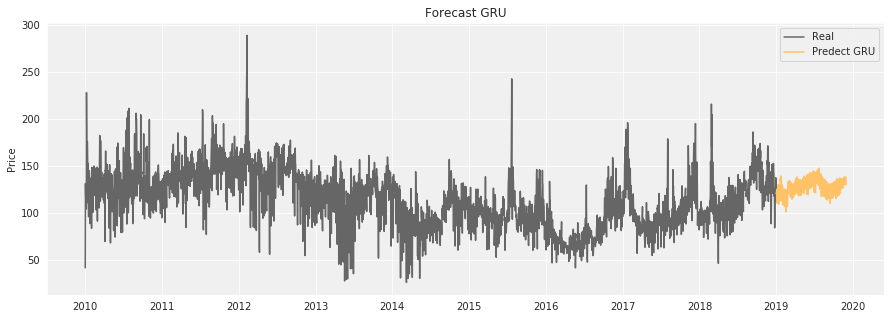

In [51]:
fig = plt.figure(figsize=(15,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Forecast SARIMA (6,1,6)x(1,1,1)7')
ax.plot(df, color='#666666', label='Real')
ax.plot(predicted_ARIMA_FINAL, color='#d966ff', label='Predect SARIMA')
plt.ylabel('Price')
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Forecast UCM')
ax.plot(df, color='#666666', label='Real')
ax.plot(predicted_UCM_FINAL, color='#00cc99', label='Predect UCM')
plt.ylabel('Price')
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Forecast GRU')
ax.plot(df, color='#666666', label='Real')
ax.plot(predicted_GRU_FINAL, color='#ffc266', label='Predect GRU')
plt.ylabel('Price')
plt.legend()
plt.show()

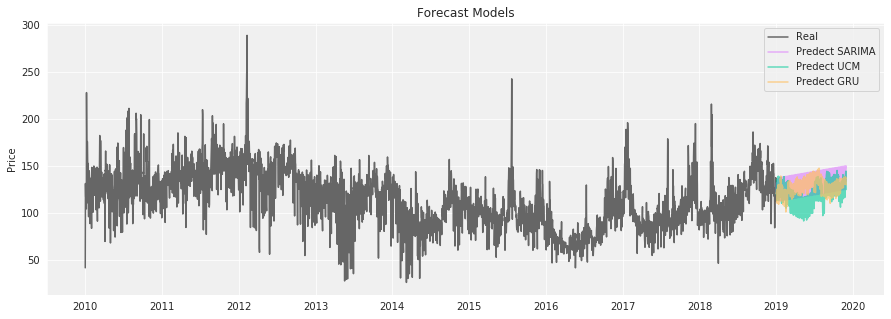

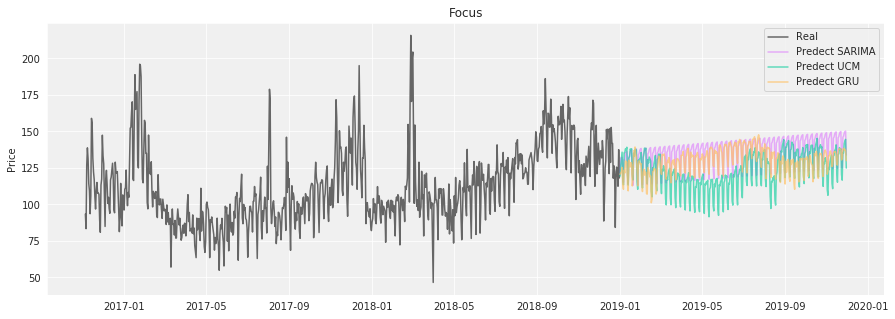

In [52]:
fig = plt.figure(figsize=(15,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Forecast Models')
ax.plot(df, color='#666666', label='Real')
ax.plot(predicted_ARIMA_FINAL, color='#d966ff', label='Predect SARIMA', alpha = 0.5)
ax.plot(predicted_UCM_FINAL, color='#00cc99', label='Predect UCM', alpha = 0.6)
ax.plot(predicted_GRU_FINAL, color='#ffc266', label='Predect GRU', alpha = 0.7)
plt.ylabel('Price')
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Focus')
ax.plot(df[2500:], color='#666666', label='Real')
ax.plot(predicted_ARIMA_FINAL, color='#d966ff', label='Predect SARIMA', alpha = 0.5)
ax.plot(predicted_UCM_FINAL, color='#00cc99', label='Predect UCM', alpha = 0.6)
ax.plot(predicted_GRU_FINAL, color='#ffc266', label='Predect GRU', alpha = 0.7)
plt.ylabel('Price')
plt.legend()
plt.show()

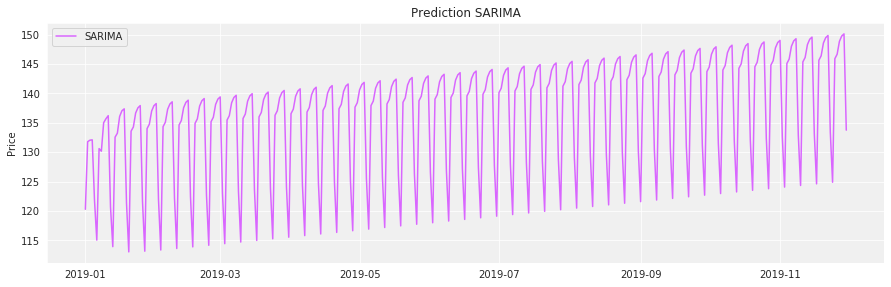

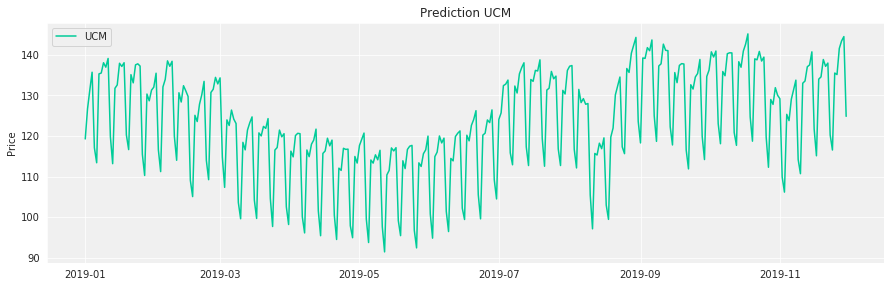

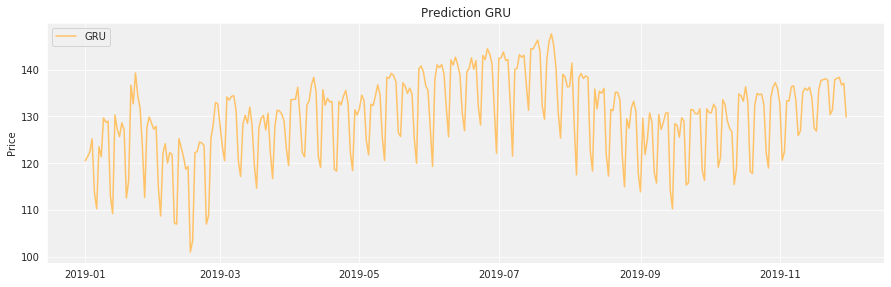

In [53]:
fig = plt.figure(figsize=(15,15))
fig.show()
ax = fig.add_subplot(311)
plt.title('Prediction SARIMA')
ax.plot(predicted_ARIMA_FINAL, color='#d966ff', label='SARIMA')
plt.ylabel('Price')
plt.legend()
plt.show()
fig = plt.figure(figsize=(15,15))
fig.show()
ax = fig.add_subplot(311)
plt.title('Prediction UCM')
ax.plot(predicted_UCM_FINAL, color='#00cc99', label='UCM')
plt.ylabel('Price')
plt.legend()
plt.show()
fig = plt.figure(figsize=(15,15))
fig.show()
ax = fig.add_subplot(311)
plt.title('Prediction GRU')
ax.plot(predicted_GRU_FINAL, color='#ffc266', label='GRU')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()